# Figure 1: Overview of NetMHCI and PRIME scores

## Import packages

In [3]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mannwhitneyu
import statistics 

In [4]:

# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'
# yellow = '#ffffd4'

In [15]:

# set up plotting 
axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12

# set font type and font size 
plt.rcParams.update({'font.sans-serif':'Arial'})

In [14]:

# get current date  
timestr = time.strftime("%Y%m%d")


## Import the data 

In [5]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [6]:

# Import PRIME and NetMHC data 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides
pred_file_prime = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/PRIME_out/scores/20240220_percent_ranks_for_each_variant_by_HLA.csv' # prediction file for PRIME

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]
pred_filename_prime = pred_file_prime.split('/')[2].split('.')[0]
pred_method_prime = pred_file_prime.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)


In [7]:

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest


In [8]:

# Organize PRIME scores 
prime = pd.read_csv(pred_file_prime)
# variants with stop codons are indicated with AposSTOP 
# this is because I couldn't write anything with * (did not accept * in path)
prime['variant'] = prime['variant'].str.replace('STOP', '*')
prime['gene_var_gt'] = prime['gene'] + '_' + prime['variant'] + '_' + prime['genotype'] # add complete genotype data
prime['gene_var'] = prime['gene'] + '_' + prime['variant']
prime = prime.rename(columns={'allele': 'HLA'}) # rename affinity column 
prime = prime.rename(columns={'min_rank': '%Rank_EL'}) # rename affinity column 
scores_prime = prime[['HLA', '%Rank_EL', 'gene', 'variant', 'genotype', 'gene_var_gt']] # select columns of interest

# remove columns with duplicated variants (for stop codons)
stop_to_remove = ['TP53_R213S', 'TP53_R196S', 'DNMT3A_R598S', 'DNMT3A_R771S', 'DNMT3A_R320S']
prime = prime[~prime['gene_var'].isin(stop_to_remove)]

# uniform HLA allele naming format
PRIME_col = prime.HLA
PRIME_formatted = PRIME_col.apply(transform_format_prime)
prime = pd.concat([prime, PRIME_formatted.rename('HLA_formatted')], axis = 1)

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc_all.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc_all.gene_var.unique()))
print('Number of alleles for which predictions are available (PRIME):', len(prime.HLA_formatted.unique()))
print('Number of unique variants (PRIME):',  len(prime.gene_var.unique()))



Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42
Number of alleles for which predictions are available (PRIME): 194
Number of unique variants (PRIME): 42


In [9]:

# check we have a common set of HLA alleles  
prime.HLA_formatted = prime.HLA_formatted.astype('category')
netmhc_all.HLA_formatted = netmhc_all.HLA_formatted.astype('category')

prime_allele = pd.Series(prime.HLA_formatted.cat.categories.tolist())
net_allele = pd.Series(netmhc_all.HLA_formatted.cat.categories.tolist())
common_alleles = prime_allele[prime_allele.isin(net_allele)].tolist()

# we are doing comparison only on the MHC alleles which are common
# there are 188 common MHC alleles for which we can generate predictions
prime = prime[prime['HLA_formatted'].isin(common_alleles)]
netmhc = netmhc[netmhc['HLA_formatted'].isin(common_alleles)]

prime_alleles_count = prime['HLA_formatted'].nunique()
net_alleles_count = netmhc['HLA_formatted'].nunique()

# write these alleles to csv 
common_alleles = pd.Series(common_alleles)
print('Predictions from both PRIME and NetMHC are available for', len(common_alleles), 'MHC alleles')

Predictions from both PRIME and NetMHC are available for 194 MHC alleles


In [10]:

# sort prime and netmhc prediction dataframes by allele name
# need to sort values so you are comparing the same things 
netmhc_all = netmhc_all.sort_values(by=['gene_var', 'genotype', 'HLA_formatted'])
prime = prime.sort_values(by=['gene_var', 'genotype', 'HLA_formatted'])

# create additional column to indicate -1 * log(%Rank_EL)
# log transform to better visualise smaller values
# convert to negative so that higher values = more immunogenic 
netmhc_all['%Rank_EL_log'] = -1 * np.log10(netmhc_all["%Rank_EL"])
netmhc_all['%Rank_BA_log'] = -1 * np.log10(netmhc_all["%Rank_BA"])
prime['%Rank_EL_log'] = -1 * np.log10(prime["%Rank_EL"])

# select specific series which contain parameters of interest 

# NetMHC
net_el_rank = netmhc_all["%Rank_EL"] 
net_ba_rank = netmhc_all["%Rank_BA"] # only available for NetMHC
net_el_score = netmhc_all["Score_EL"] # only available for NetMHC
net_ba_score = netmhc_all["Score_BA"] # only available for NetMHC
net_el_rank_log = netmhc_all["%Rank_EL_log"] # only available for NetMHC
net_ba_rank_log = netmhc_all["%Rank_BA_log"] # only available for NetMHC
net_sum_05 = netmhc_all["sum_peptides_below_05"]
net_sum_2= netmhc_all["sum_peptides_below_2"] 

# PRIME
prime_el_rank = prime["%Rank_EL"] 
prime_sum_05 = prime["sum_peptides_below_05"]
prime_sum_2= prime["sum_peptides_below_2"] 
prime_el_rank_log = prime["%Rank_EL_log"] 


# Correlation between scores

In [11]:

from matplotlib.ticker import FixedLocator, MultipleLocator
from matplotlib.ticker import FuncFormatter

# make sure that the axis ticks are integers (-1, 1, 2, and not -1.0, 1.0, 2.0)
def custom_format(x, pos):
    return f'{int(x)}' if x == int(x) else f'{x}'


In [12]:

# define a function for plotting correlations between scores from NetMHC and PRIME

from itertools import chain

def plot_prime_netmhc_comparison(net_values, prime_values, param, color, option = None):
    
    plt.figure(figsize=(4, 4)) # set figure size
    
    # create a scatterplot or a regplot depending on the option required
    if option == 'regplot': # can add fitting a regression model 
        a = sns.regplot(x = net_values, y = prime_values, color = color, marker = 'o', scatter_kws={'s':5})

    else:
        a = sns.scatterplot(x = net_values, y = prime_values, s = 15, alpha = 0.7, color = color)

    plt.title(f'{param}', fontsize = 14)
    plt.xlabel(f'NetMHC', fontsize = 12)
    plt.ylabel(f'PRIME', fontsize = 12)

    r, p = sp.stats.pearsonr(x = net_values, y = prime_values)
    plt.text(.8, .9, 'r={:.2f}'.format(r), transform=a.transAxes, fontsize = 10)
    
    min_x = min(-1, 1.1 * min(chain(*[net_values, prime_values]))) # take the lower of -0.1 or the minimum value 
    min_y = min(-1, 1.1 * min(chain(*[net_values, prime_values]))) # take the lower of -0.1 or the minimum value

    plt.xlim(min_x, 1.1 * max(chain(*[net_values, prime_values]))) # make sure x-axis and y-axis scale is the same 
    plt.ylim(min_y, 1.1 * max(chain(*[net_values, prime_values]))) # max value in either of the two lists 

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    if option == 'regplot':
        plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_{param}_regplot.pdf", bbox_inches = "tight")
    else:
        plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_{param}.pdf", bbox_inches = "tight")


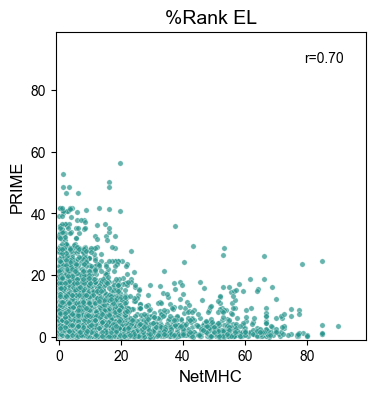

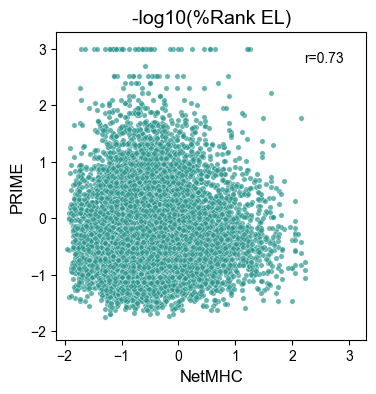

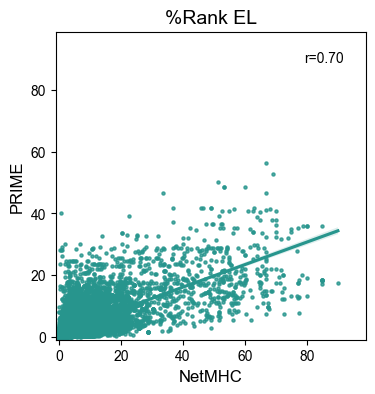

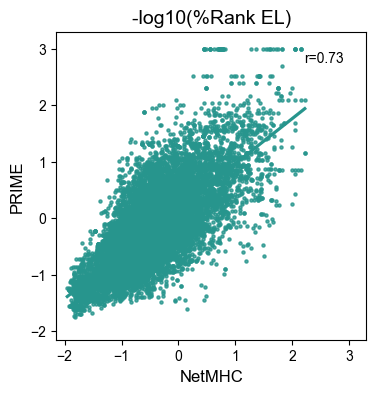

In [16]:

color = '#27958d'

plot_prime_netmhc_comparison(net_el_rank, prime_el_rank, '%Rank EL', color)
plot_prime_netmhc_comparison(net_el_rank_log, prime_el_rank_log, '-log10(%Rank EL)', color)
plot_prime_netmhc_comparison(net_el_rank, prime_el_rank, '%Rank EL', color, 'regplot')
plot_prime_netmhc_comparison(net_el_rank_log, prime_el_rank_log, '-log10(%Rank EL)', color, 'regplot')

# In conclusion, there is moderate positive correlation between scores
# I would be a bit more confident in these if the correlation was higher 


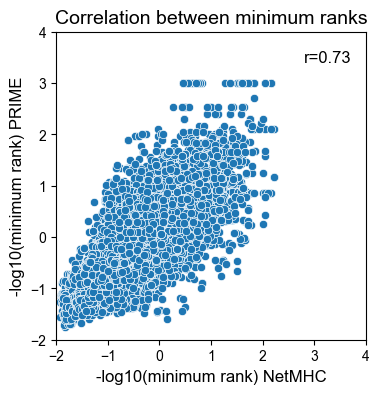

In [72]:

# SANITY CHECK 

prime['min_rank_log_prime'] = prime['%Rank_EL_log']
netmhc_all['min_rank_log_netmhc'] = netmhc_all['%Rank_EL_log']

prime_df = prime[['HLA_formatted', 'gene_var', 'genotype', 'min_rank_log_prime']]
netmhc_df = netmhc_all[['HLA_formatted', 'gene_var', 'genotype', 'min_rank_log_netmhc']]
merged_min_rank = pd.merge(prime_df, netmhc_df, on=['HLA_formatted', 'gene_var', 'genotype'])

plt.figure(figsize=(4, 4)) # set figure size
p8 = sns.scatterplot(y='min_rank_log_prime', x='min_rank_log_netmhc', data = merged_min_rank)
p8.set(xlabel = '-log10(min rank in NetMHC)', ylabel = '-log10(min rank in PRIME)')
r, p = sp.stats.pearsonr(y=merged_min_rank['min_rank_log_prime'], x=merged_min_rank['min_rank_log_netmhc']) # pearson correlation
plt.text(.8, .9, 'r={:.2f}'.format(abs(r)), transform=p8.transAxes, fontsize = 12) # add corr coefficient

plt.ylim(-2, 4)
plt.xlim(-2, 4)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('-log10(minimum rank) NetMHC', fontsize = 12)
plt.ylabel('-log10(minimum rank) PRIME', fontsize = 12)

plt.title('Correlation between minimum ranks', fontsize = 14)
plt.show()
# okay you get the same thing so that means this is the correct result


In [80]:
# I think I would also like to do it for individual CH variants just to see if there are any that are particularly good / bad 

variants = prime.gene_var_gt.unique().tolist() # we have the same for netmhc and prime so it does not matter which df you take it from
r_coeffs = []

for var in variants:

    var_name = var.replace('_', ' ')

    # make sure the dataframes are sorted 
    prime = prime.sort_values(by = ['HLA_formatted', 'gene_var_gt'])
    netmhc_all = netmhc_all.sort_values(by = ['HLA_formatted', 'gene_var_gt'])

    # select -log10(%Rank_EL)
    prime_el_rank_log = prime[prime['gene_var_gt'] == var]['%Rank_EL_log'].tolist()
    net_el_rank_log = netmhc_all[netmhc_all['gene_var_gt'] == var]['%Rank_EL_log'].tolist()
    plot_prime_netmhc_comparison(net_el_rank_log, prime_el_rank_log, f'-log10(%Rank EL) {var_name}', color)
    plt.close()
    
    # would be useful to have actual correlation coefficients to plot it so let's calculate and append to list
    r, p = sp.stats.pearsonr(x = net_el_rank_log, y = prime_el_rank_log) 
    r_coeffs.append(r)

# plot distribution of correlation coefficients
plt.figure(figsize = (6,3))
plt.hist(r_coeffs, edgecolor = 'black', color = color)

plt.xlabel('r coefficient', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Distirbution of correlation coefficient values for individual variants', fontsize = 18)

plt.xlim(0, 1)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_dist_of_corr_coeff_across_variants.pdf", bbox_inches = "tight")


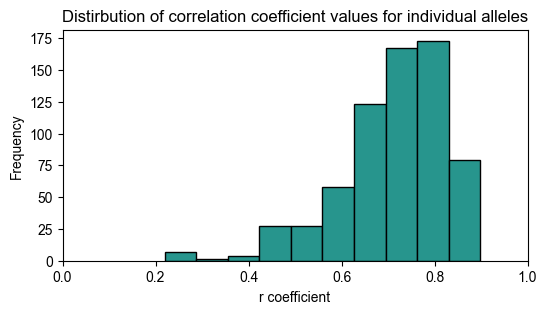

In [86]:
 

alleles = prime.HLA_formatted.unique().tolist()

for allele in alleles:

    # make sure the dataframes are sorted 
    prime = prime.sort_values(by = ['HLA_formatted', 'gene_var_gt'])
    netmhc_all = netmhc_all.sort_values(by = ['HLA_formatted', 'gene_var_gt'])

    # select -log10(%Rank_EL)
    prime_el_rank_log = prime[prime['HLA_formatted'] == allele]['%Rank_EL_log'].tolist()
    net_el_rank_log = netmhc_all[netmhc_all['HLA_formatted'] == allele]['%Rank_EL_log'].tolist()

    # would be useful to have actual correlation coefficients to plot it so let's calculate and append to list
    r, p = sp.stats.pearsonr(x = net_el_rank_log, y = prime_el_rank_log) 
    r_coeffs.append(r)

plt.figure(figsize = (6,3))
plt.hist(r_coeffs, edgecolor = 'black', color = color)

plt.xlabel('r coefficient', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Distirbution of correlation coefficient values for individual alleles', fontsize = 18)

plt.xlim(0, 1)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_dist_of_corr_coeff_across_alleles.pdf", bbox_inches = "tight")


## Distribution of scores across CH variants

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_7380/1946059510.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_min_rank_melt_ch['median_log_score'] = merged_min_rank_melt_ch.groupby('gene_var')['value'].transform('median')
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_7380/1946059510.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 20)
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_7380/1946059510.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

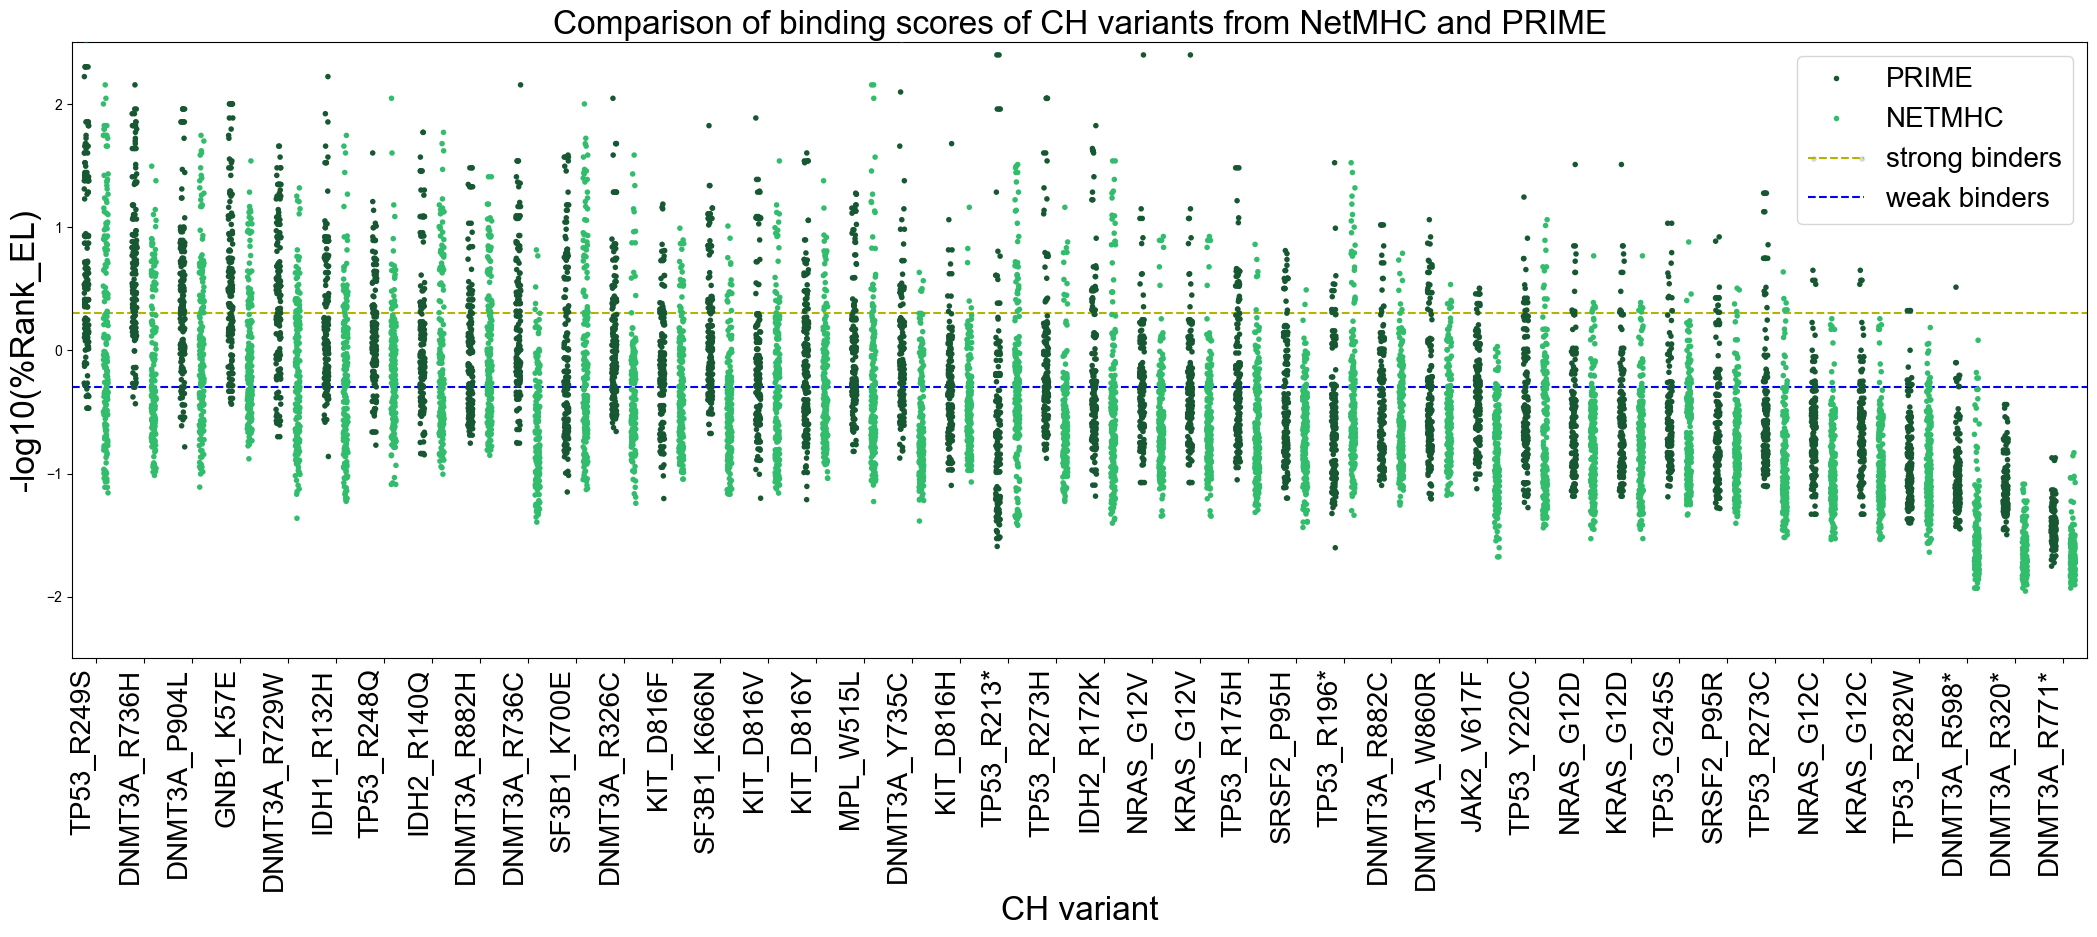

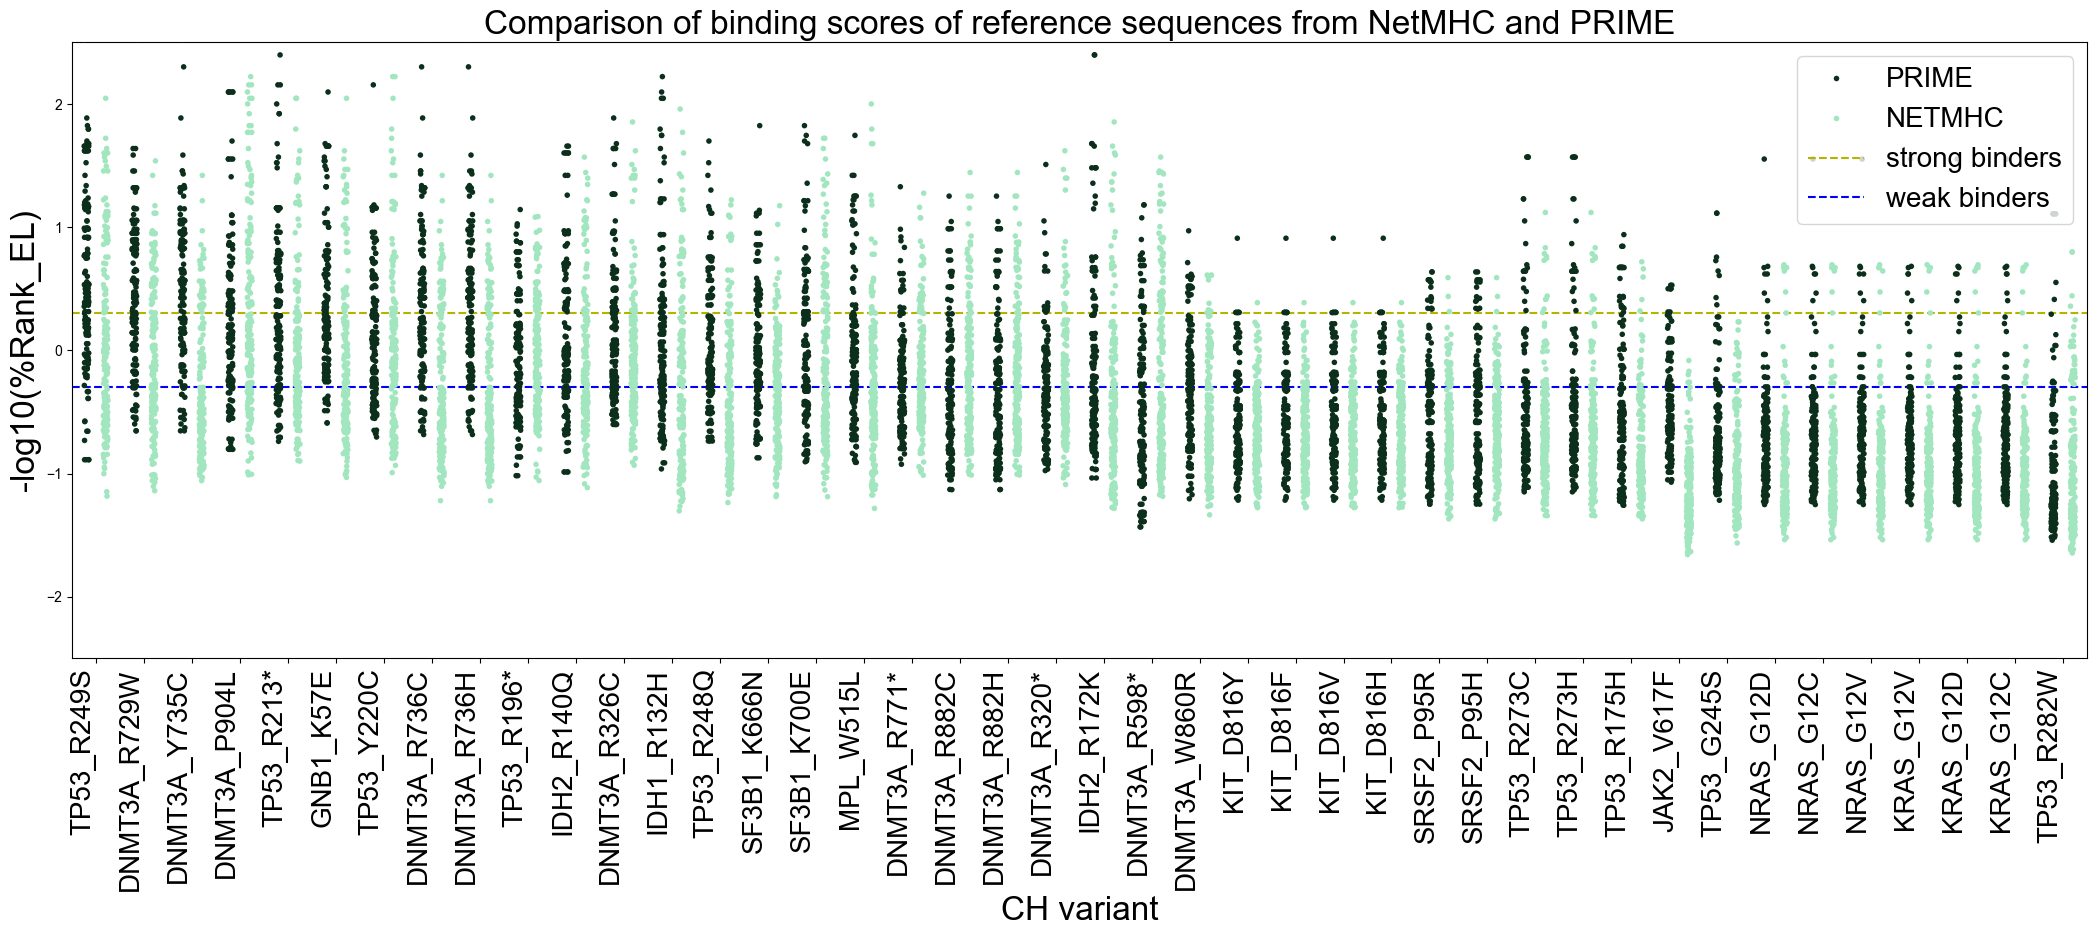

In [87]:

# Plot a jitterplot to compare scores derived from PRIME and NetMHC across variants
merged_min_rank_melt = pd.melt(merged_min_rank, id_vars = ['HLA_formatted', 'gene_var', 'genotype'])
merged_min_rank_melt['method'] = merged_min_rank_melt['variable'].str.split('_').str[3]
merged_min_rank_melt['method'] = merged_min_rank_melt['method'].str.upper()
merged_min_rank_melt_ch = merged_min_rank_melt[merged_min_rank_melt['genotype'] == 'ch']

# colors 
colors = ['#175833', '#32bd6d']

# sort variants by median score 
merged_min_rank_melt_ch['median_log_score'] = merged_min_rank_melt_ch.groupby('gene_var')['value'].transform('median')
merged_min_rank_melt_ch_sort = merged_min_rank_melt_ch.sort_values(by='median_log_score', ascending = False)

plt.figure(figsize = (26, 8))
p1 = sns.stripplot(x = 'gene_var', y = 'value', hue = 'method', data = merged_min_rank_melt_ch_sort, palette = colors, size = 4, jitter = True, dodge = True) # jitter

plt.title(f'Comparison of binding scores of CH variants from NetMHC and PRIME', fontsize = 24)
plt.xlabel('CH variant', fontsize = 24)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 20)
plt.ylabel('-log10(%Rank_EL)', fontsize = 24)

plt.ylim(-2.5, 4)
# add thresholds for strong and weak binding (from software)
plt.axhline(y=-1*np.log10(0.5), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)

plt.legend(fontsize = 20)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_for_each_variant_EL_rank_log_strip_ch_only.pdf", bbox_inches = "tight")

# for reference variants
merged_min_rank_melt_refseq = merged_min_rank_melt[merged_min_rank_melt['genotype'] == 'refseq']
merged_min_rank_melt_refseq['median_log_score'] = merged_min_rank_melt_refseq.groupby('gene_var')['value'].transform('median')
merged_min_rank_melt_refseq_sort = merged_min_rank_melt_refseq.sort_values(by='median_log_score', ascending = False)

colors = ['#0c2f1c', '#a1e6bf']

plt.figure(figsize = (26, 8))
p1 = sns.stripplot(x = 'gene_var', y = 'value', hue = 'method', data = merged_min_rank_melt_refseq_sort, palette = colors, size = 4, jitter = True, dodge = True) # jitter
plt.title(f'Comparison of binding scores of reference sequences from NetMHC and PRIME', fontsize = 24)
plt.xlabel('CH variant', fontsize = 24)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 20)
plt.ylabel('-log10(%Rank_EL)', fontsize = 24)
plt.ylim(-2.5, 4)
plt.axhline(y=-1*np.log10(0.5), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)
plt.legend(fontsize = 20)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_for_each_variant_EL_rank_log_strip_refseq_only.pdf", bbox_inches = "tight")


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_7380/812834283.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 24)
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_7380/812834283.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 24)


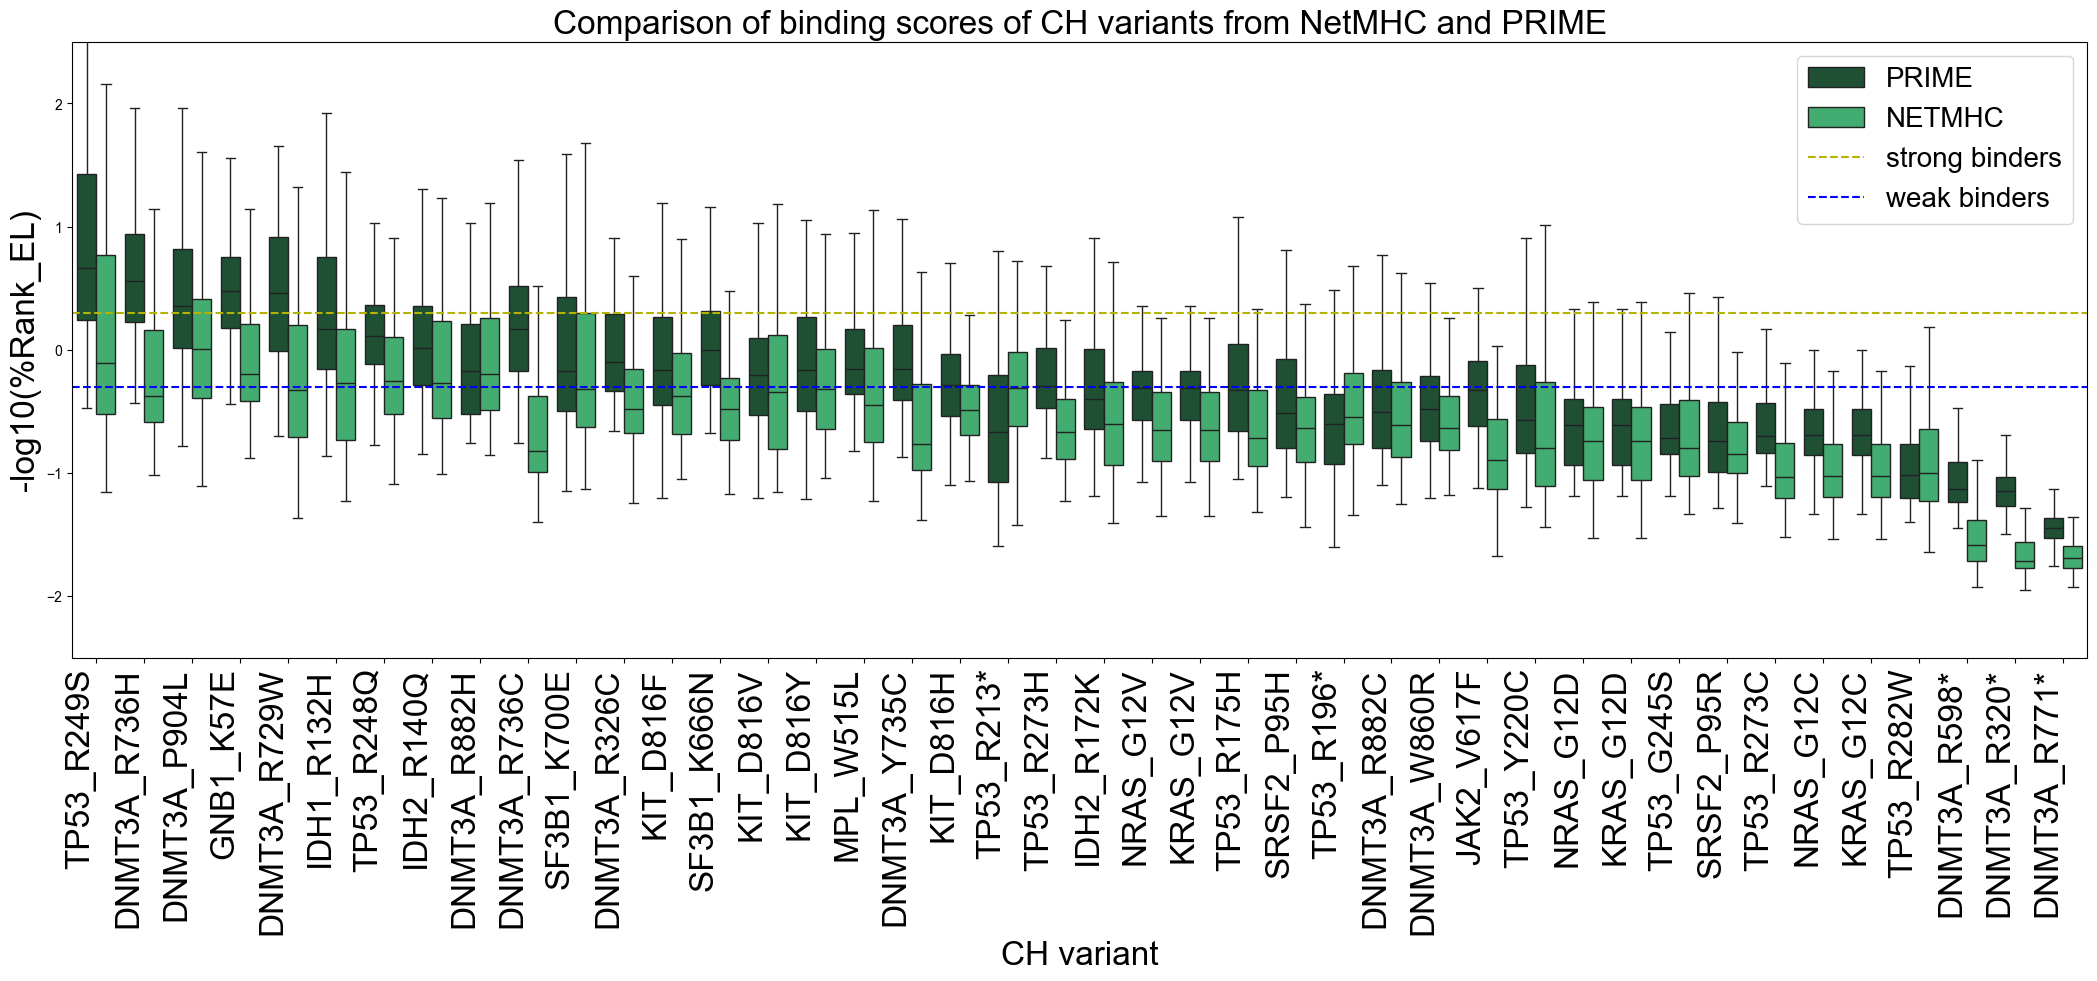

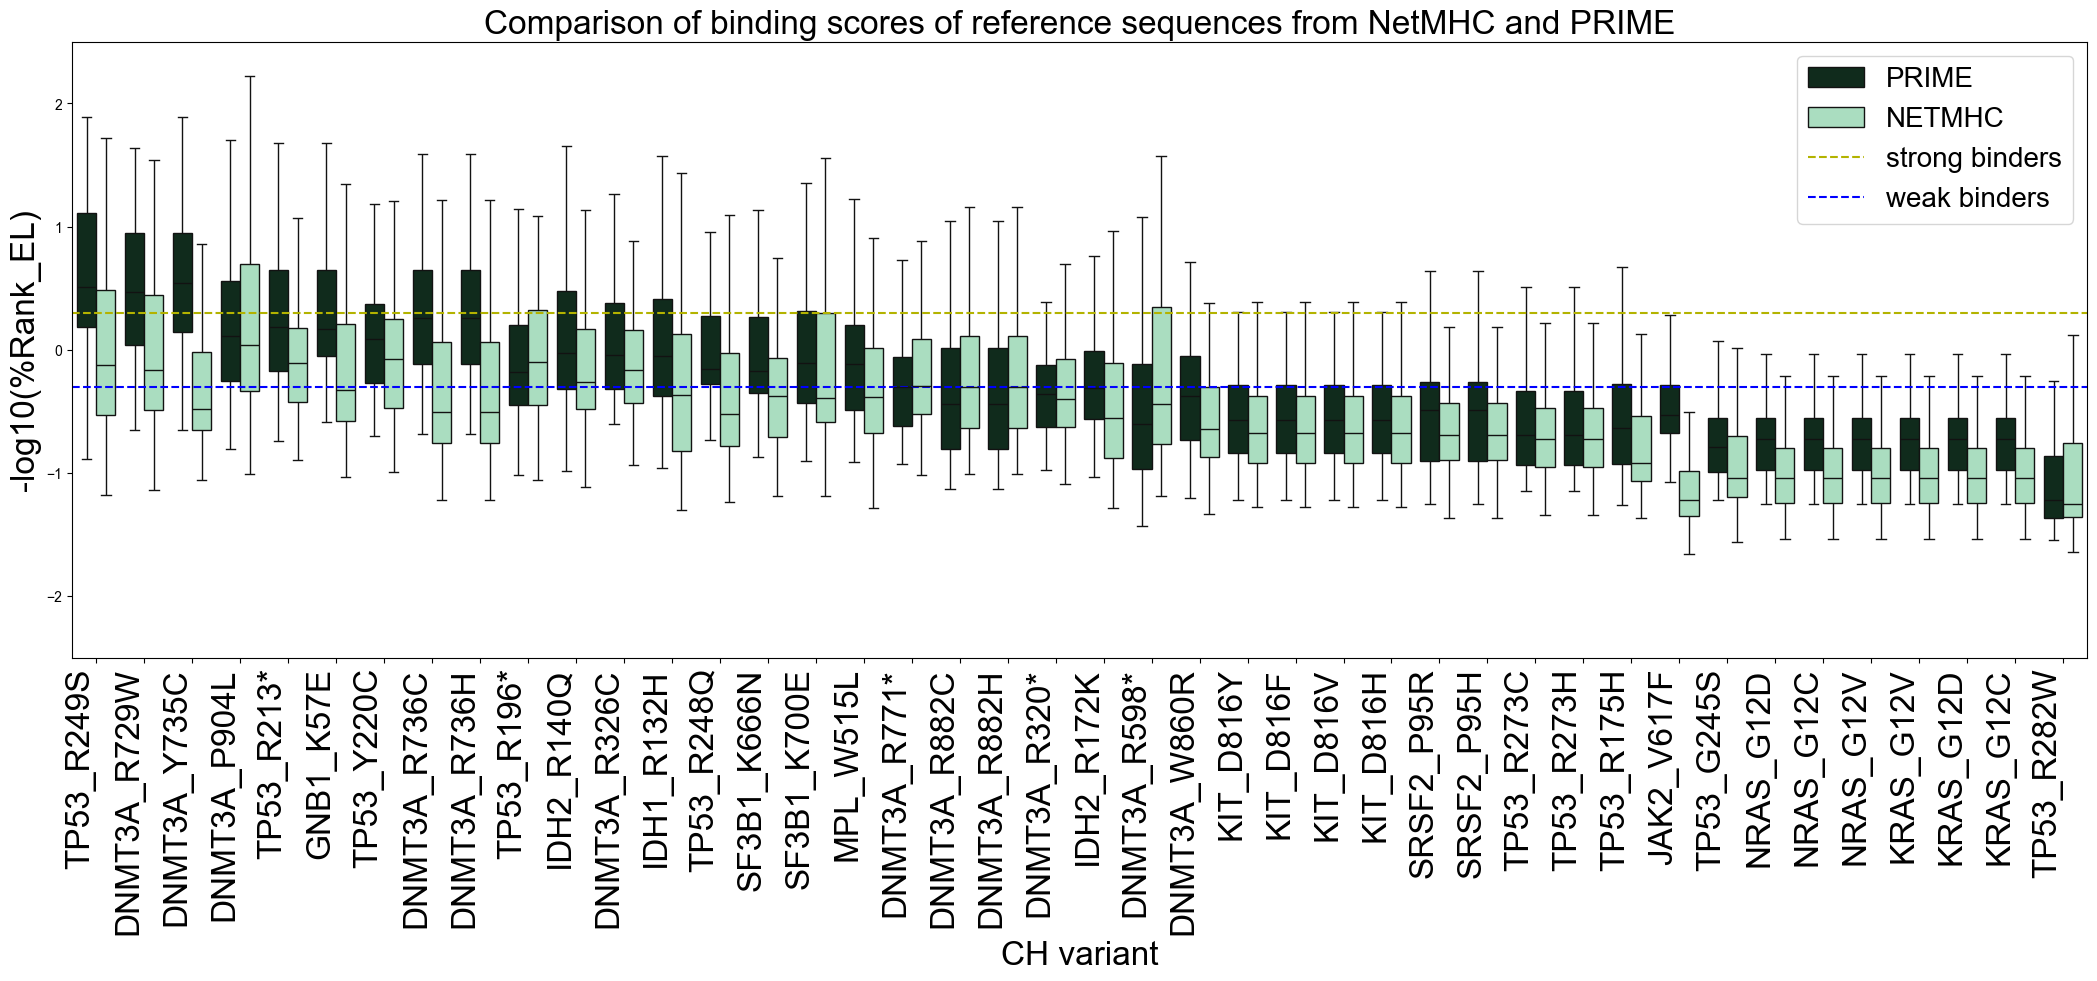

In [88]:

# boxplot
# CH
colors = ['#175833', '#32bd6d']
plt.figure(figsize = (26, 8))
p1 = sns.boxplot(x = 'gene_var', y = 'value', hue = 'method', data = merged_min_rank_melt_ch_sort, palette = colors, showfliers = False) # boxplot

plt.title(f'Comparison of binding scores of CH variants from NetMHC and PRIME', fontsize = 24)
plt.xlabel('CH variant', fontsize = 24)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 24)
plt.ylabel('-log10(%Rank EL)', fontsize = 24)

plt.ylim(-2.5, 4)
# add thresholds for strong and weak binding (from software)
plt.axhline(y=-1*np.log10(0.5), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)

plt.legend(fontsize = 20)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_for_each_variant_EL_rank_log_box_ch.pdf", bbox_inches = "tight")

# refseq
colors = ['#0c2f1c', '#a1e6bf']

plt.figure(figsize = (26, 8))
p1 = sns.boxplot(x = 'gene_var', y = 'value', hue = 'method', data = merged_min_rank_melt_refseq_sort, palette = colors, showfliers = False) # boxplot
plt.title(f'Comparison of binding scores of reference sequences from NetMHC and PRIME', fontsize = 24)
plt.xlabel('CH variant', fontsize = 24)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right", fontsize = 24)
plt.ylabel('-log10(%Rank EL)', fontsize = 24)
plt.ylim(-2.5, 4)
plt.axhline(y=-1*np.log10(0.5), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=0.5 (indicates strong binding)
plt.axhline(y=-1*np.log10(2), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=2 (indicates weak binding)
plt.legend(fontsize = 20)
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_for_each_variant_EL_rank_log_box_refseq.pdf", bbox_inches = "tight")


## Heatmaps

In [89]:

# make heatmaps to compare
prime['method'] = 'PRIME'
netmhc_all['method'] = 'NetMHC'

prime['gene_var'] = prime['gene_var'].astype('str')
netmhc_all['gene_var'] = netmhc_all['gene_var'].astype('str')

prime['label'] = prime['gene_var'] + "_" + prime['genotype'] + "_" + prime['method']
netmhc_all['label'] = netmhc_all['gene_var'] + "_" + netmhc_all['genotype'] + "_" + netmhc_all['method']

prime_sub = prime.drop('min_rank_log_prime', axis=1)
netmhc_sub = netmhc_all.drop('min_rank_log_netmhc', axis =1)

df = pd.concat([prime_sub, netmhc_sub], axis=0)
df = df.reset_index()

# select -log10 (minimum rank) value for plotting 
df_min_rank_log = df.loc[:, ('HLA_formatted', '%Rank_EL_log', 'label')]

label_encoder = LabelEncoder() 
df_min_rank_log['HLA_formatted'] = label_encoder.fit_transform(df_min_rank_log['HLA_formatted']) # transform labels 

df_min_rank_heatmap = df.pivot(index='HLA_formatted', columns='label', values='%Rank_EL_log') # create a df for plotting 
sort_columns = sorted(df_min_rank_heatmap.columns, key=lambda x: x.split('_')[0:1]) # sort the df 

# Create a new df with the reordered columns
df_heatmap_sorted = df_min_rank_heatmap[sort_columns] 

In [106]:

# Define plotting function 

def plot_heatmap(df, palette, xlabel, ylabel, param, name):
    plt.figure(figsize = (40,15))
    h1 = sns.heatmap(df, cmap=palette, yticklabels=False, cbar_kws = dict(use_gridspec=True,location="right")) # move legend bar to the top
    h1.set_ylabel(ylabel, fontsize = 40)
    h1.set_xlabel(xlabel, fontsize = 40)
    cbar_kws = {"label": param}
    cbar = h1.collections[0].colorbar
    cbar.set_label(cbar_kws["label"], fontsize = 30)
    plt.xticks(fontsize=20)  
    plt.title('Binding affinity scores', fontsize = 50)
    plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_heatmap_{param}_{name}.pdf", bbox_inches = "tight")


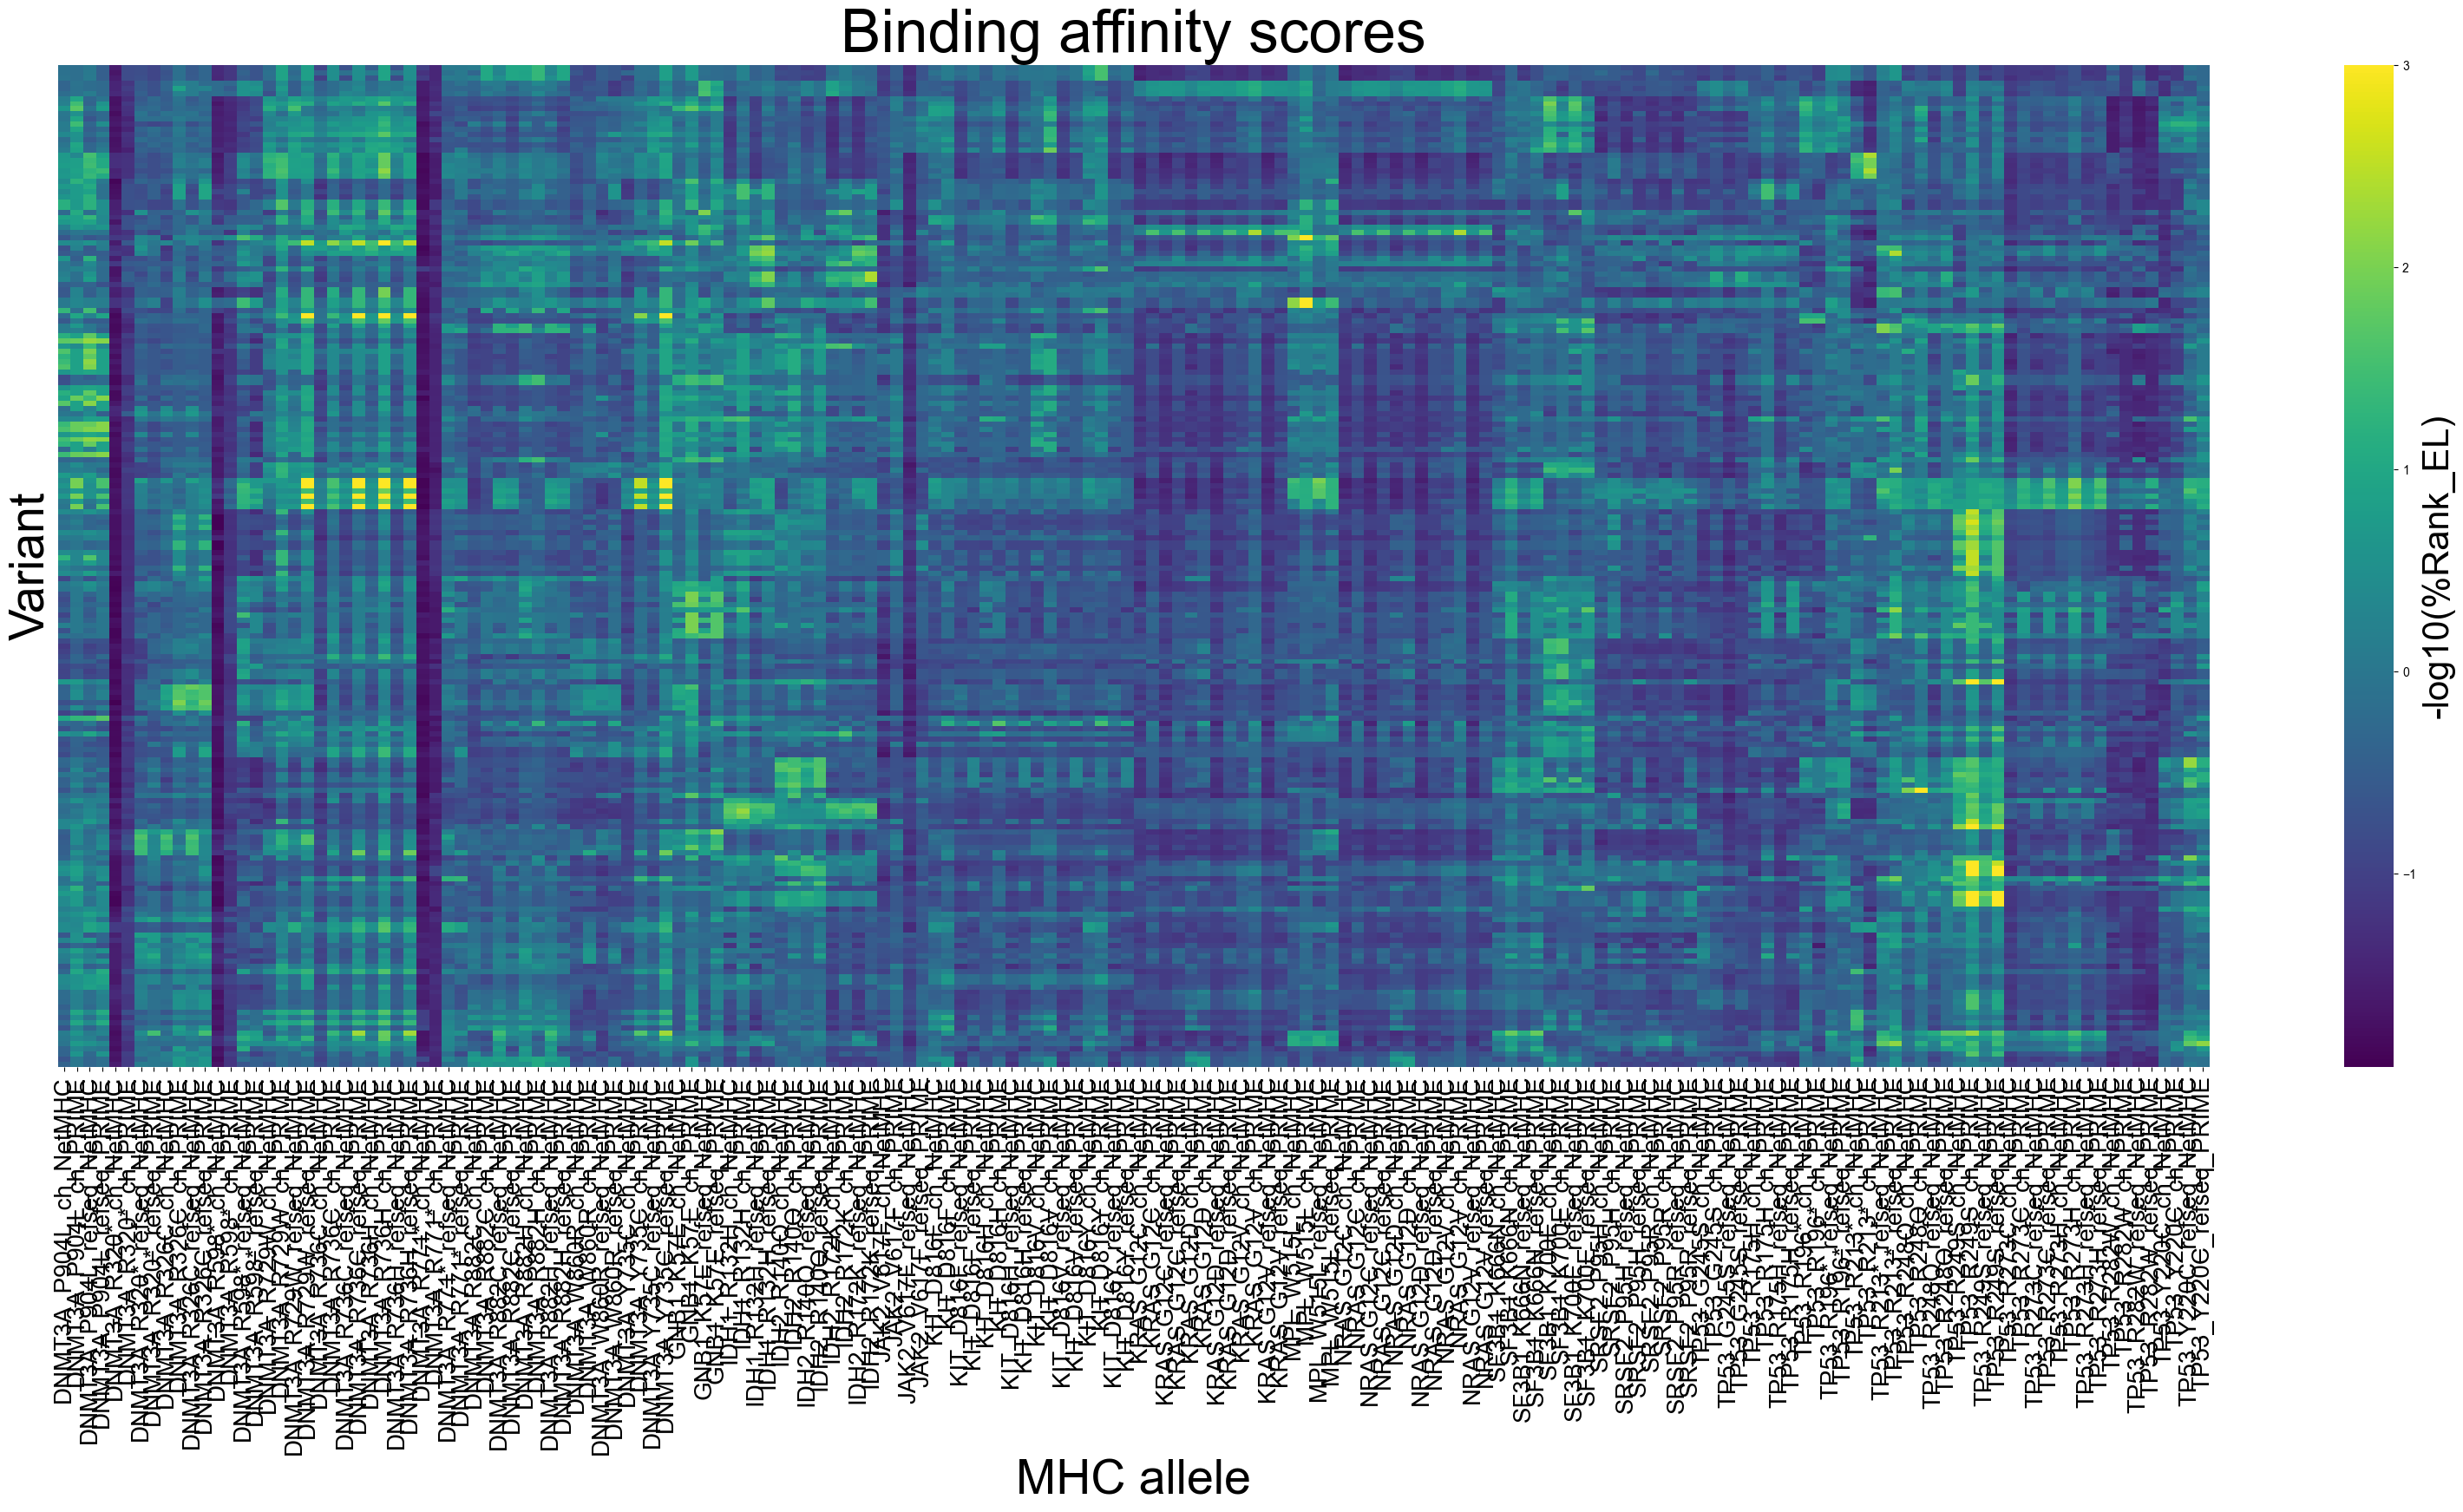

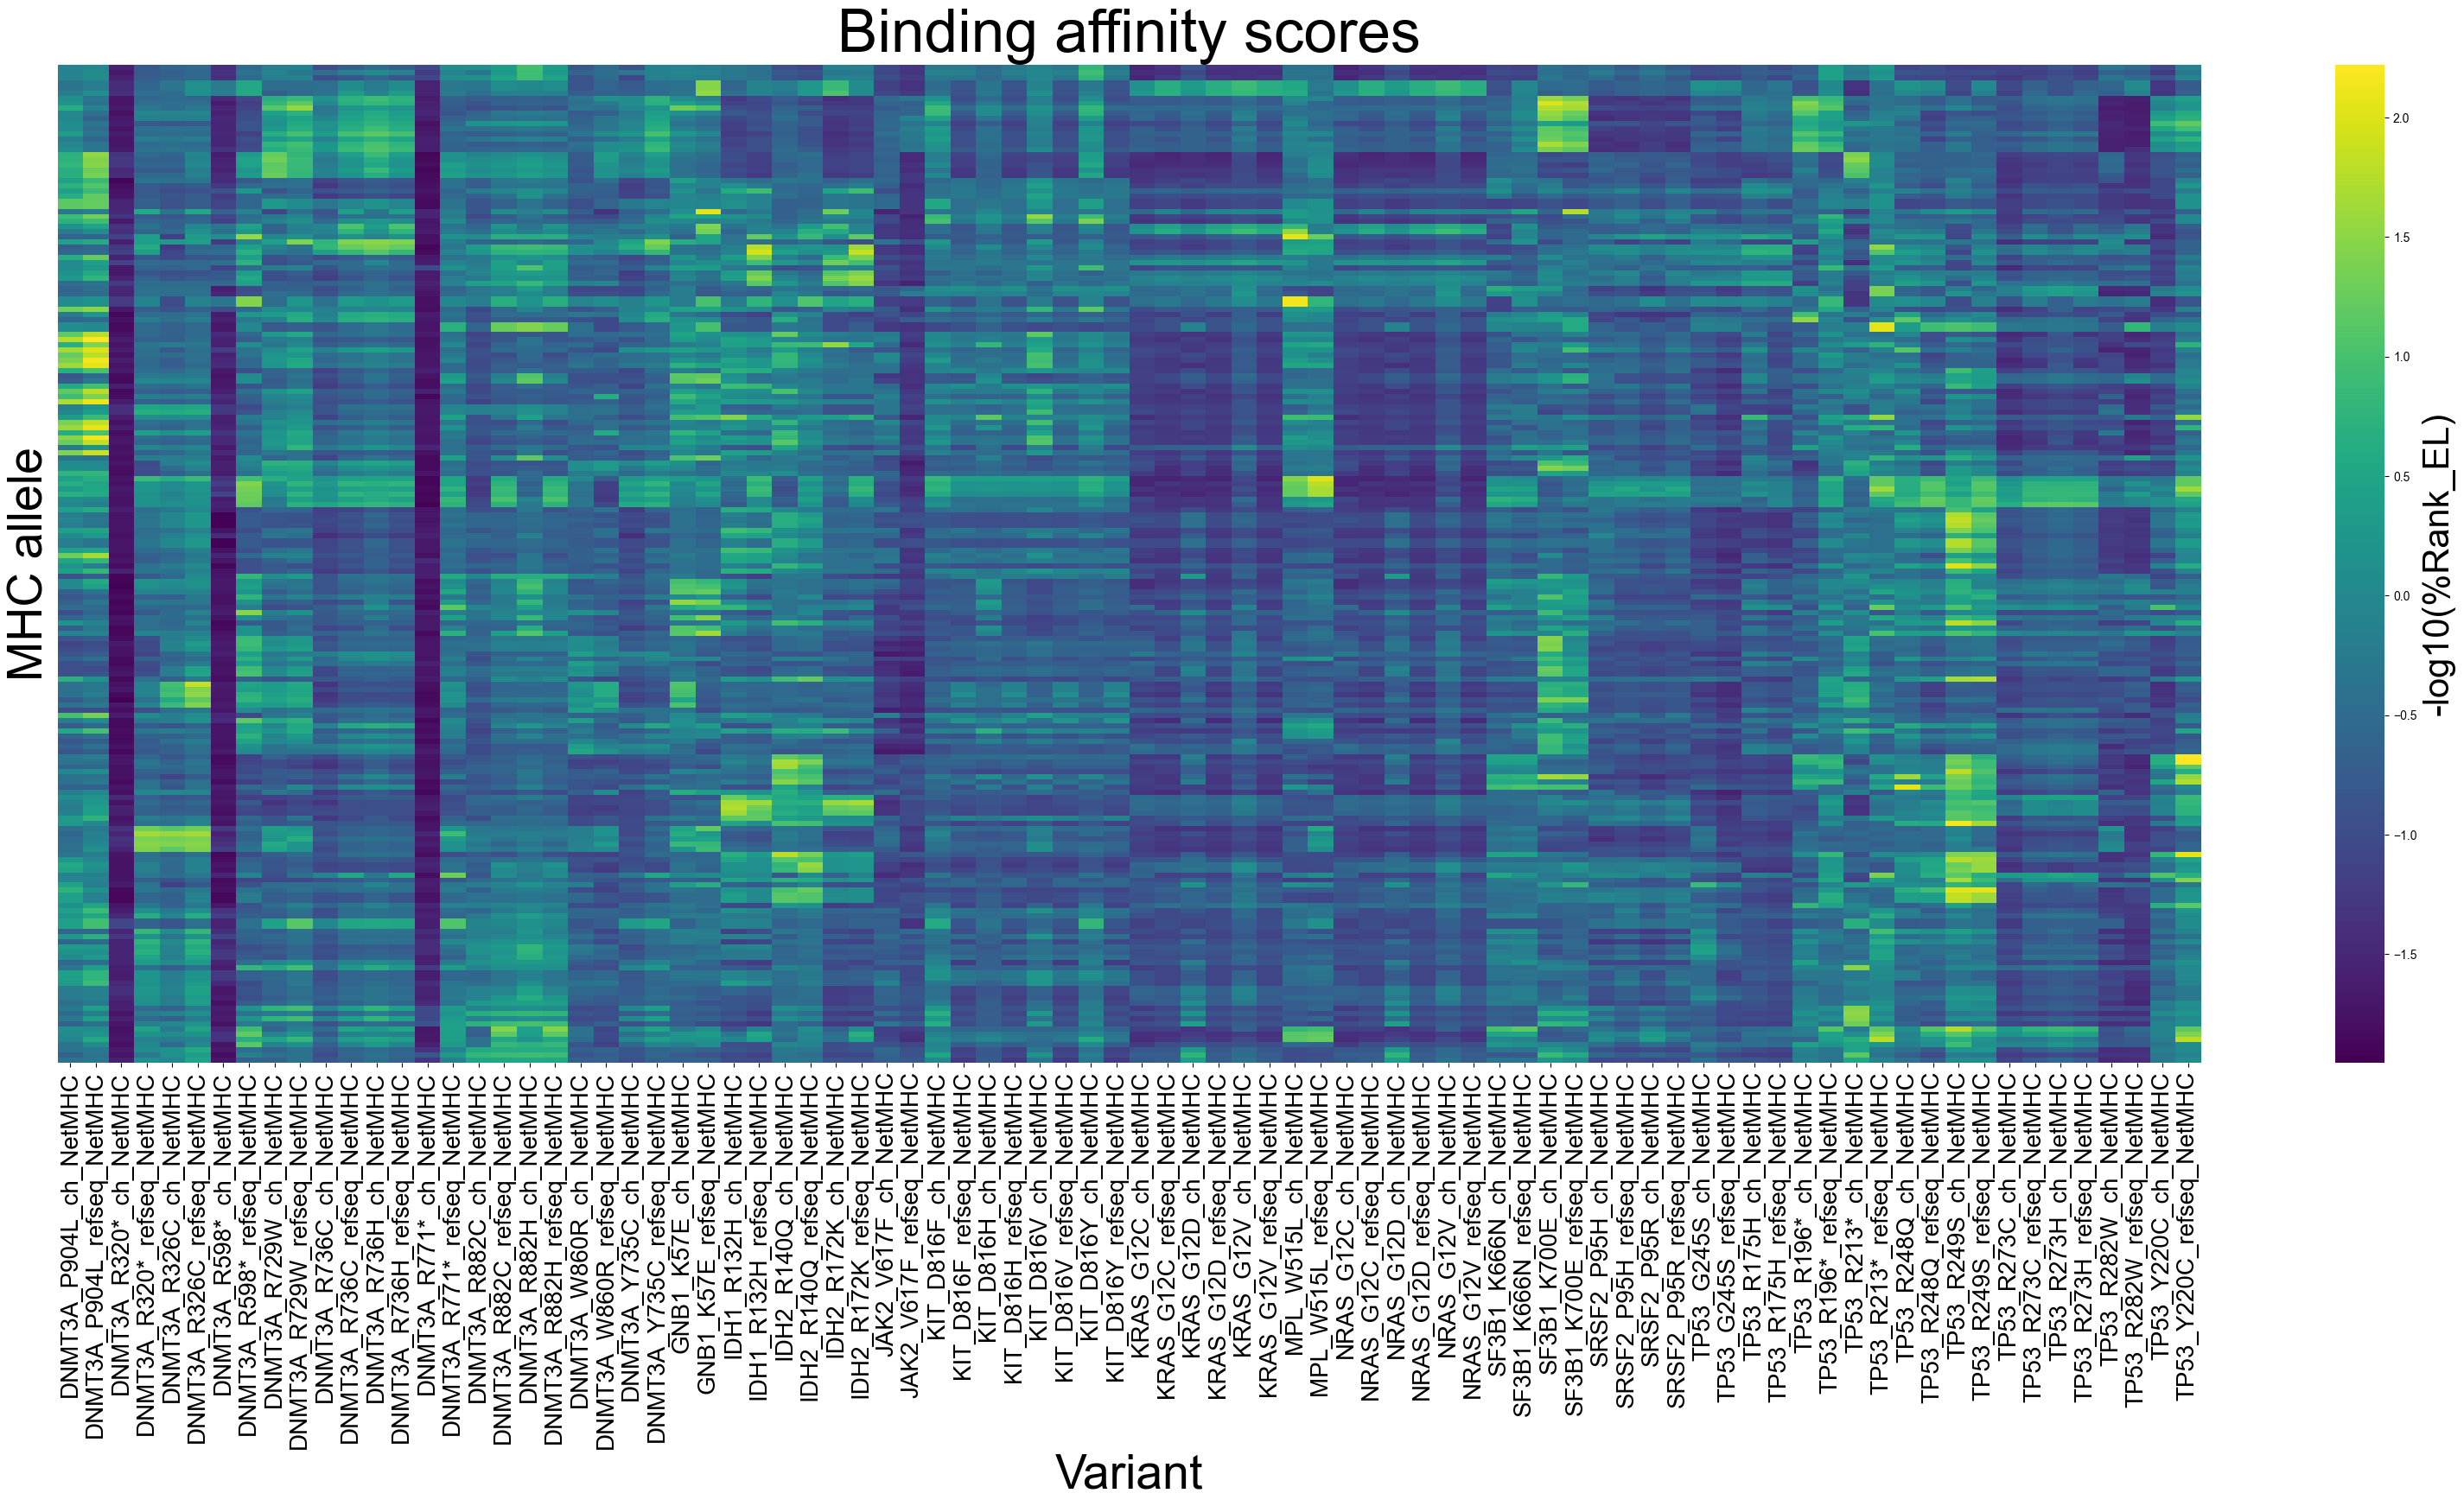

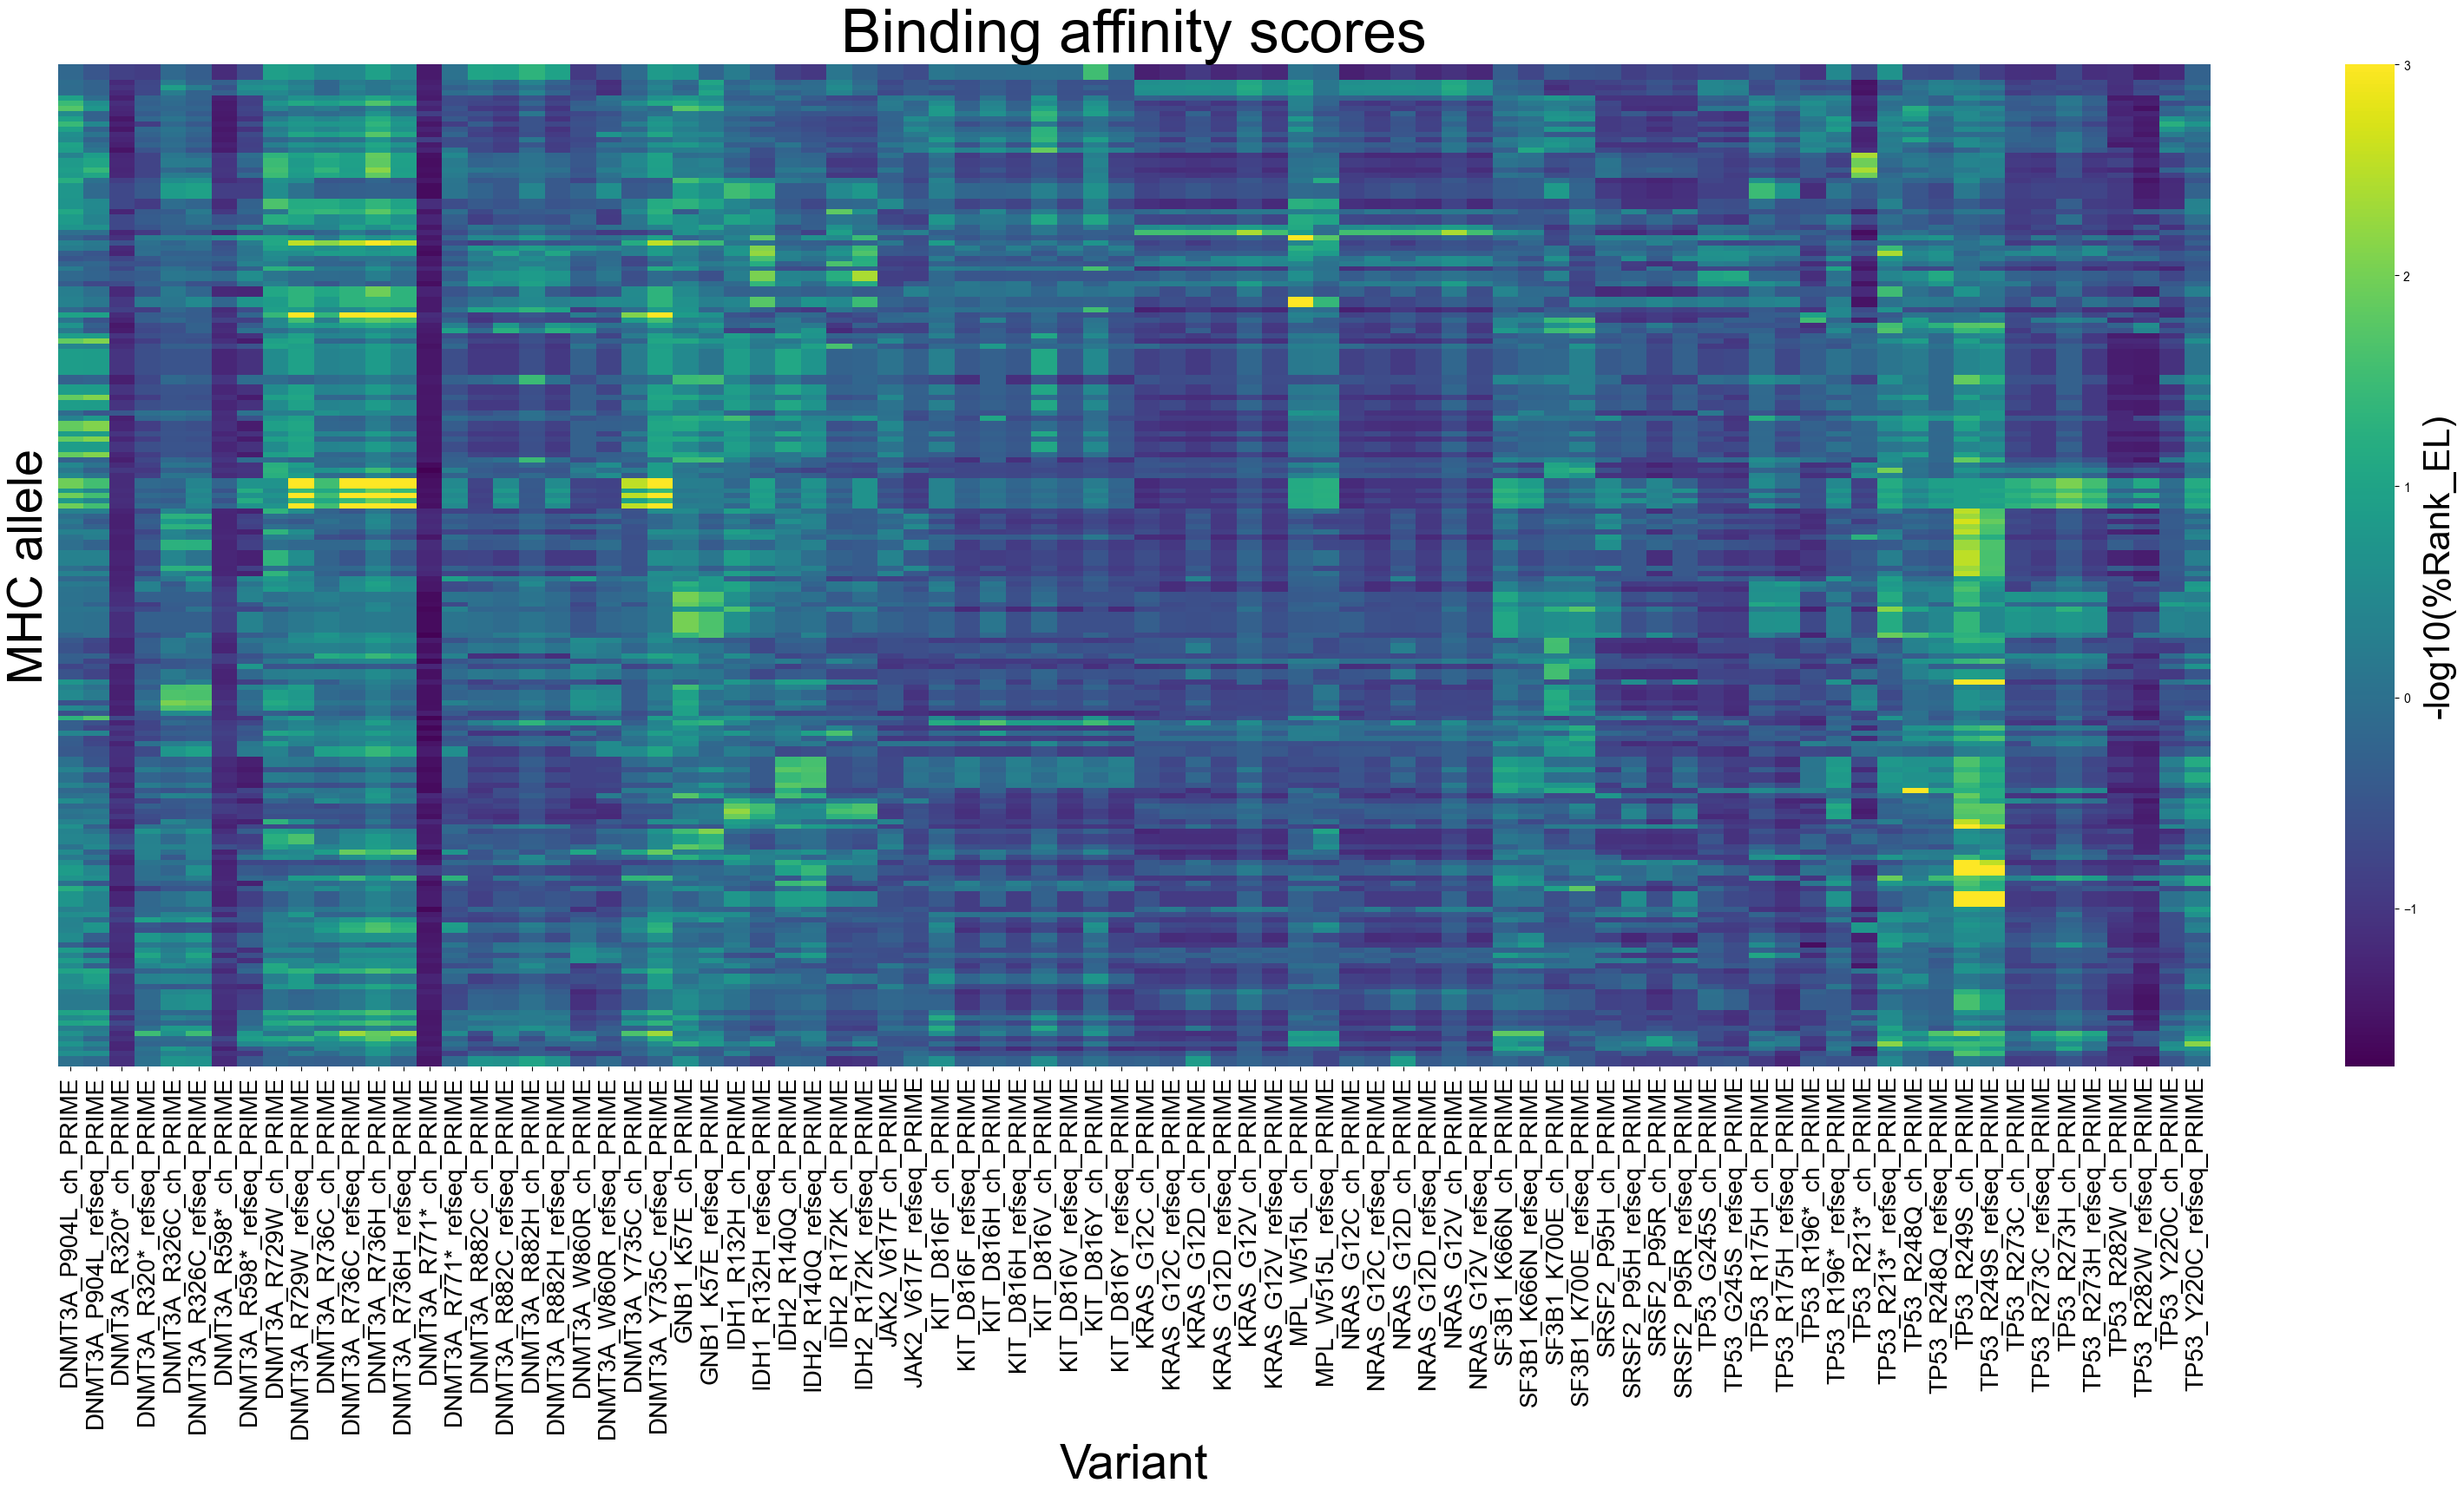

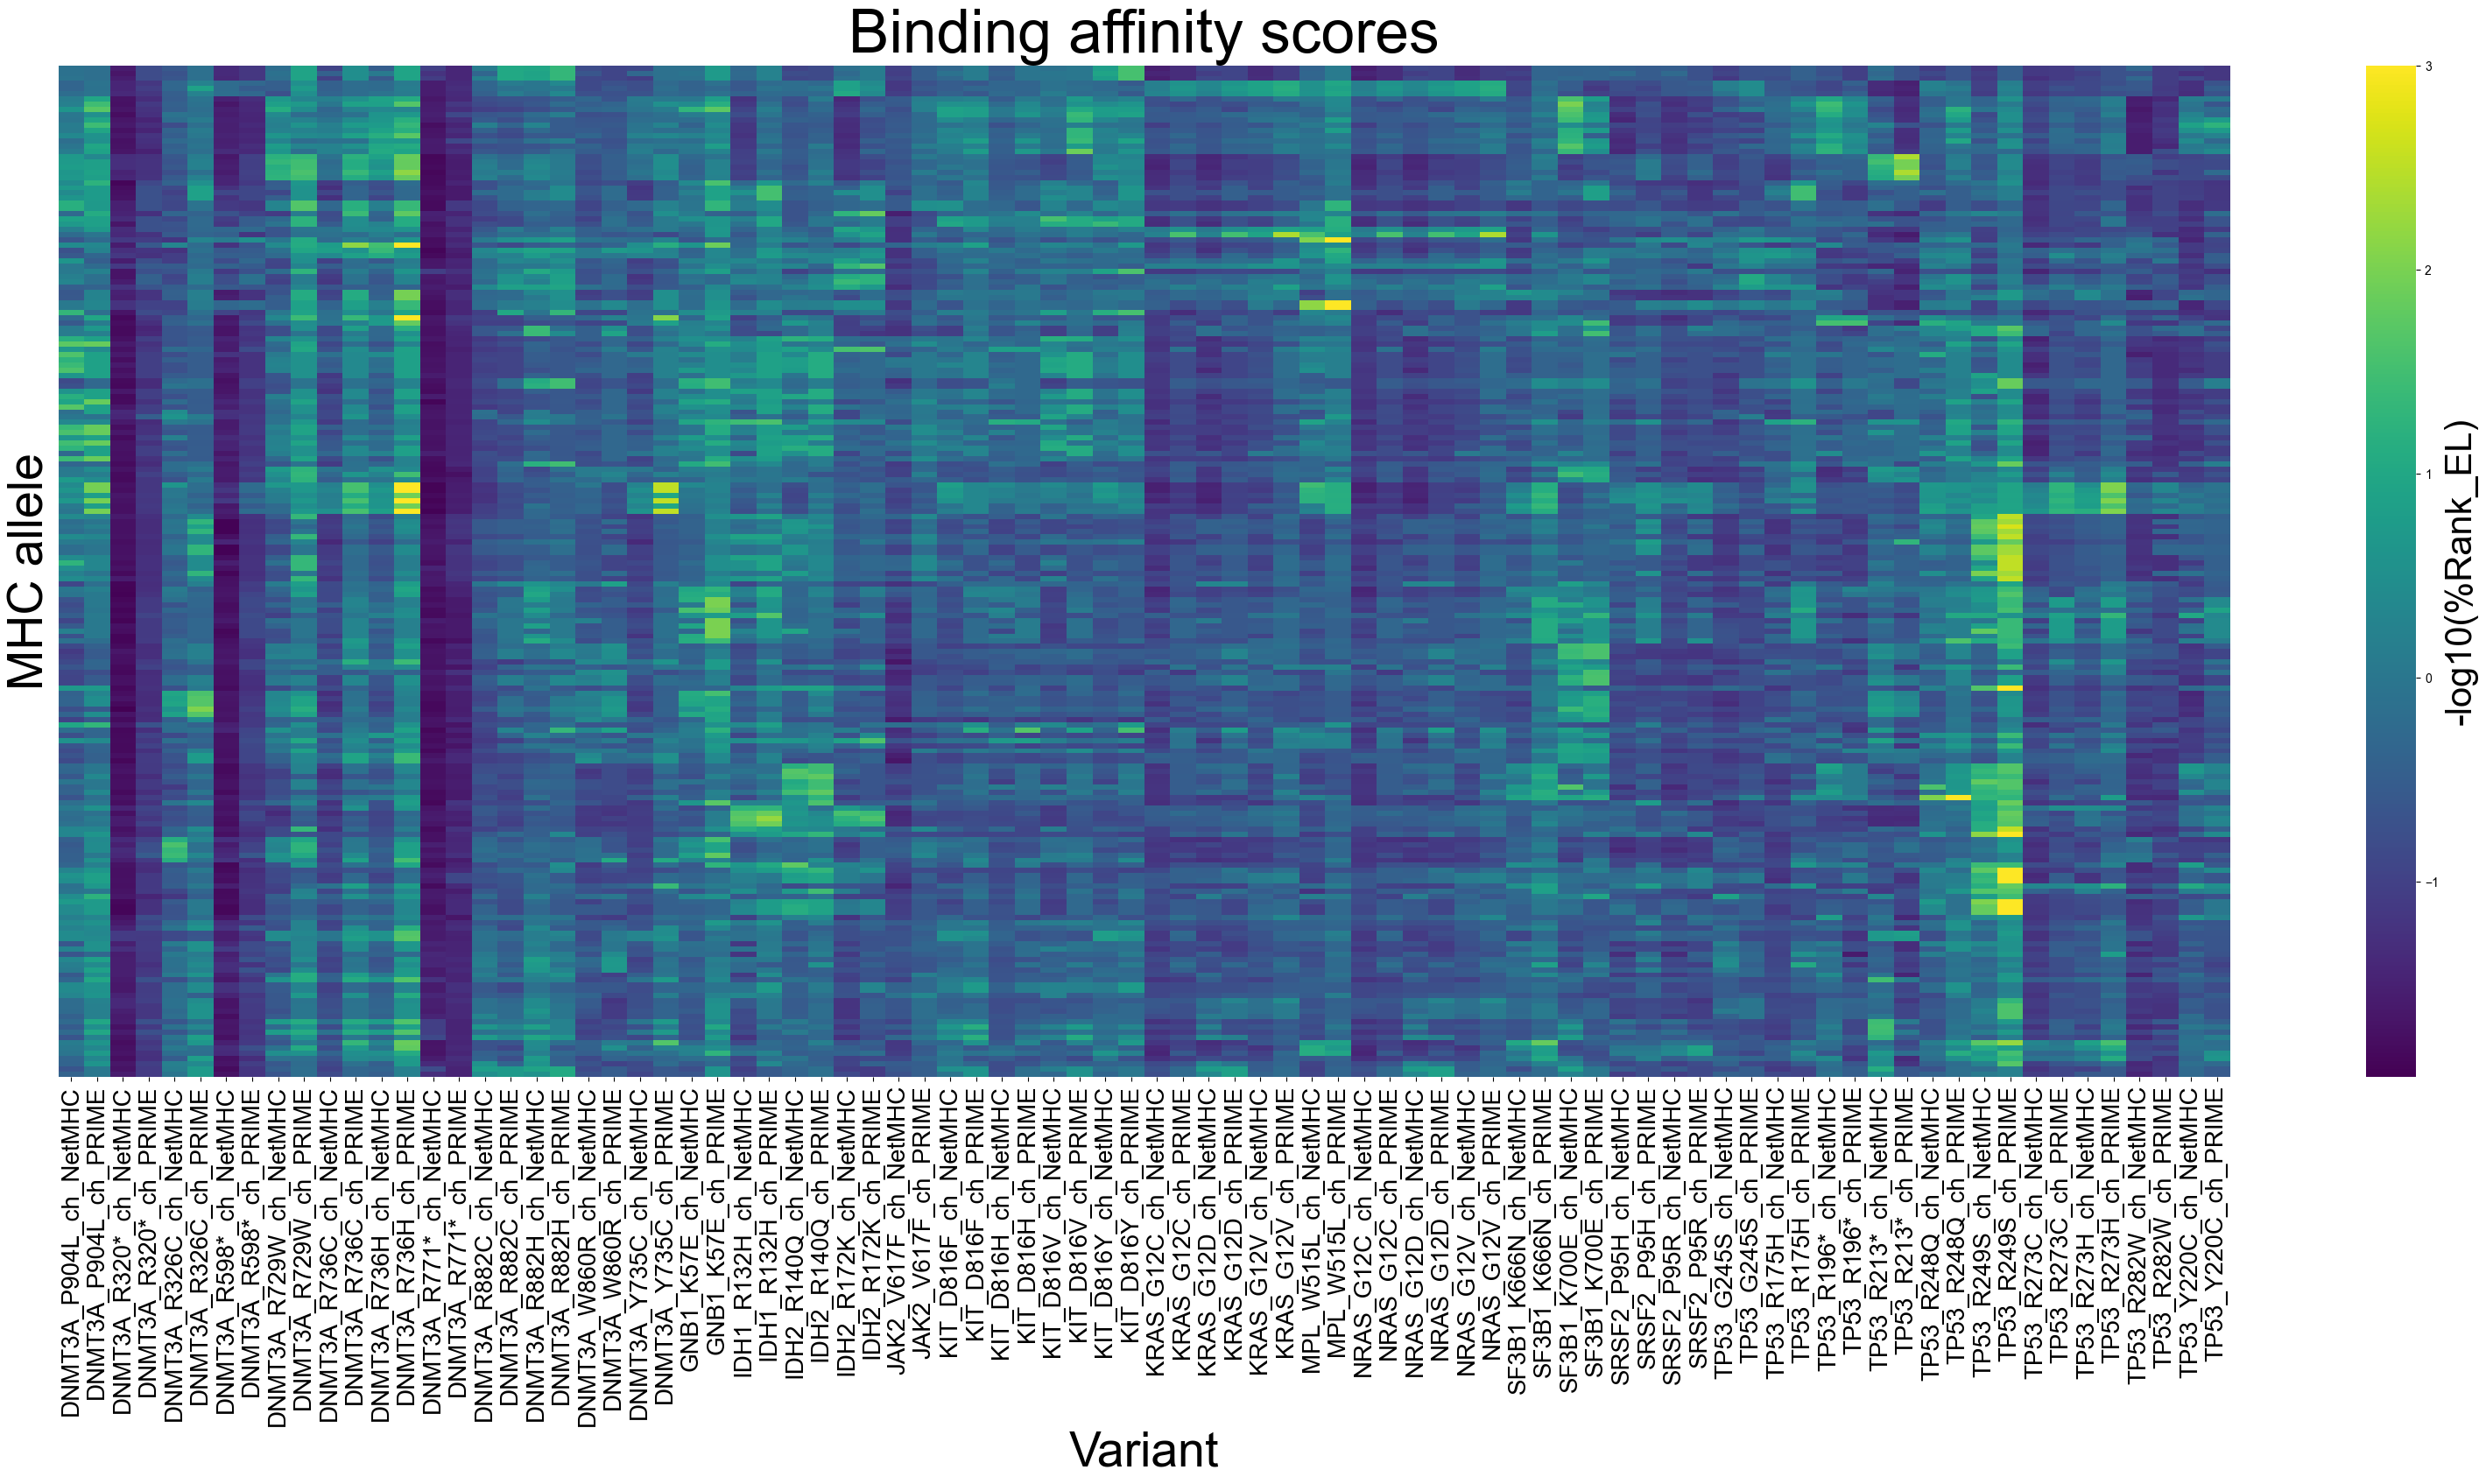

In [107]:

# Create heatmaps 

# plot all results 
plot_heatmap(df_heatmap_sorted[sort_columns], 'viridis', 'MHC allele', 'Variant', '-log10(%Rank_EL)', 'NetMHC_vs_PRIME')

df_netmhc = df_heatmap_sorted.filter(regex='_NetMHC$', axis=1) # select only NetMHC predictions
df_prime = df_heatmap_sorted.filter(regex='_PRIME$', axis=1) # select only PRIME predictions

# plot NetMHC and PRIME separately
plot_heatmap(df_netmhc, 'viridis', 'Variant', 'MHC allele', '-log10(%Rank_EL)', 'NetMHC')
plot_heatmap(df_prime, 'viridis', 'Variant', 'MHC allele', '-log10(%Rank_EL)', 'PRIME')

df_ch = df_heatmap_sorted.filter(regex='_ch_', axis=1) # select only PRIME predictions
plot_heatmap(df_ch, 'viridis', 'Variant', 'MHC allele', '-log10(%Rank_EL)', 'CH variants')

# Based on this, we can conclude that scores are broadly similar
# Some peptides (probably with a bit more extreme values) are clearly picked up by both methods
# However, quite often the predictions do not exactly match 
# PRedictions are more similar for refseq / ch within method rather than for ch or refseq between methods 


## Correlation of scores between alleles

In [104]:

# Plot heatmap of correlation coefficients 

def plot_heatmap_corr(df, palette, xlabel, ylabel, param, name):
    plt.figure(figsize=(6,6)) # set figure size
    h1 = sns.heatmap(df, cmap=palette, yticklabels = False, xticklabels = False, cbar_kws={'label': 'correlation coefficient'})
    
    h1.set_xlabel(xlabel)
    h1.set_ylabel(ylabel)

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)

    plt.title(name, fontsize = 14)

    cbar = h1.collections[0].colorbar
    cbar.set_label('correlation coefficient', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_heatmap_corr_{param}_{name}.pdf", bbox_inches = "tight")

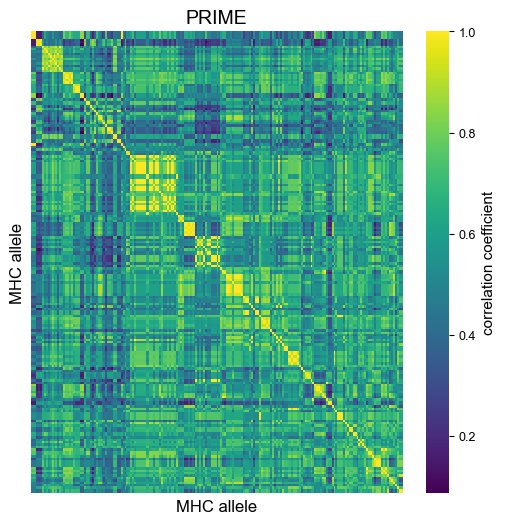

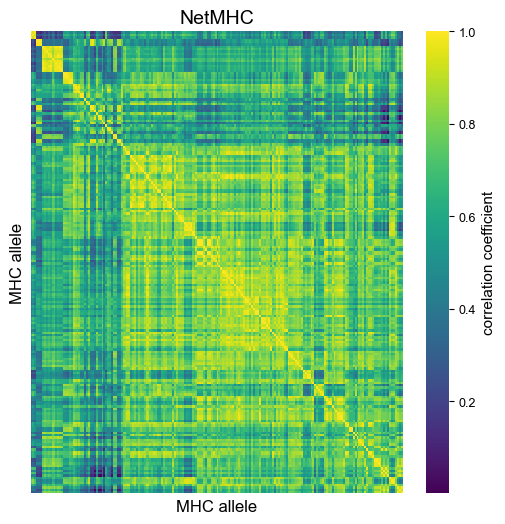

In [105]:

# correlation between scores for each of these variants for different MHC alleles

prime_scores = prime[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
prime_scores_wide = pd.pivot(prime_scores, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')
prime_scores_wide = prime_scores_wide.reset_index()

netmhc_scores = netmhc_all[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
netmhc_scores_wide = pd.pivot(netmhc_scores, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')
netmhc_scores_wide = netmhc_scores_wide.reset_index()

# examine the correlation systamatically for each HLA pair
prime_pairwise_corr = prime_scores_wide.iloc[:,1:195].corr().abs()
netmhc_pairwise_corr = netmhc_scores_wide.iloc[:,1:195].corr().abs()

plot_heatmap_corr(prime_pairwise_corr, 'viridis', 'MHC allele', 'MHC allele', 'minimum rank', 'PRIME')
plot_heatmap_corr(netmhc_pairwise_corr, 'viridis', 'MHC allele', 'MHC allele', 'minimum rank', 'NetMHC')


## How are scores for each CH variant distributed?

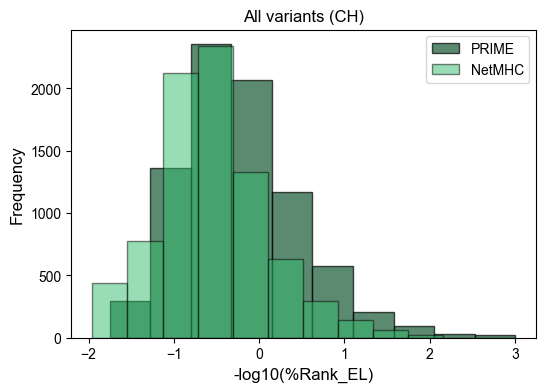

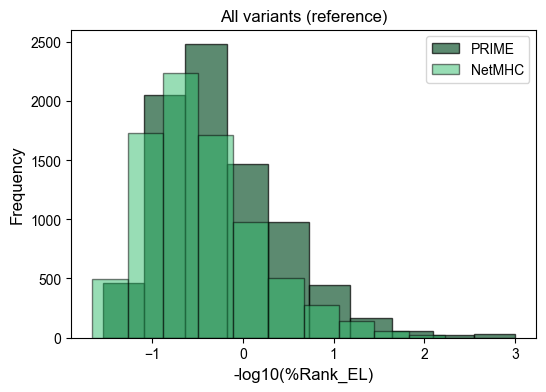

In [115]:

# Histogram of scores - aggregate
# CH
values_n = merged_min_rank_melt_ch_sort[merged_min_rank_melt_ch_sort['method'] == 'NETMHC']['value'].to_list() # value corresponds to -log10(%Rank_EL)
values_p = merged_min_rank_melt_ch_sort[merged_min_rank_melt_ch_sort['method'] == 'PRIME']['value'].to_list() # value corresponds to -log10(%Rank_EL)

plt.figure(figsize=(6, 4)) # set figure size
plt.hist(values_p, label = 'PRIME', color = '#175833', alpha = 0.7, edgecolor = 'black')
plt.hist(values_n, label = 'NetMHC', color = '#32bd6d', alpha = 0.5, edgecolor = 'black')

plt.xlabel('-log10(%Rank_EL)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title(f'All variants (CH)')

plt.xlim(-2.5, 4)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend()
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_min_rank_histogram_aggregate_ch.pdf", bbox_inches = "tight")

# refseq 
values_n = merged_min_rank_melt_refseq_sort[merged_min_rank_melt_refseq_sort['method'] == 'NETMHC']['value'].to_list() # value corresponds to -log10(%Rank_EL)
values_p = merged_min_rank_melt_refseq_sort[merged_min_rank_melt_refseq_sort['method'] == 'PRIME']['value'].to_list() # value corresponds to -log10(%Rank_EL)

plt.figure(figsize=(6, 4)) # set figure size
plt.hist(values_p, label = 'PRIME', color = '#175833', alpha = 0.7, edgecolor = 'black')
plt.hist(values_n, label = 'NetMHC', color = '#32bd6d', alpha = 0.5, edgecolor = 'black')

plt.xlabel('-log10(%Rank_EL)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title(f'All variants (reference)', fontsize = 18)

plt.xlim(-2.5, 4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_min_rank_histogram_aggregate_refseq.pdf", bbox_inches = "tight")

In [114]:

# Histogram of scores - for each gene variant (CH) separately

# identify all variants 
gene_vars = merged_min_rank_melt_ch_sort['gene_var'].unique()

# plot histogram for each variant 
for gene_var in gene_vars:

    var_name = gene_var.replace("_", " ")

    # CH 
    subset_data = merged_min_rank_melt_ch_sort[merged_min_rank_melt_ch_sort['gene_var'] == gene_var]
    values_n = subset_data[subset_data['method'] == 'NETMHC']['value'].to_list() # value corresponds to -log10(%Rank_EL)
    values_p = subset_data[subset_data['method'] == 'PRIME']['value'].to_list() # value corresponds to -log10(%Rank_EL)
    
    plt.figure(figsize=(4, 4)) # set figure size
    plt.hist(values_p, label = 'PRIME', color = '#175833', alpha = 0.7, edgecolor = 'black')
    plt.hist(values_n, label = 'NetMHC', color = '#32bd6d', alpha = 0.5, edgecolor = 'black')
    plt.xlabel('-log10(%Rank_EL)', fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    plt.title(f'{var_name}')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()

    plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_min_rank_histogram_{gene_var}_ch.pdf", bbox_inches = "tight")
    plt.close()

    # refseq 
    subset_data = merged_min_rank_melt_refseq_sort[merged_min_rank_melt_refseq_sort['gene_var'] == gene_var]
    values_n = subset_data[subset_data['method'] == 'NETMHC']['value'].to_list() # value corresponds to -log10(%Rank_EL)
    values_p = subset_data[subset_data['method'] == 'PRIME']['value'].to_list() # value corresponds to -log10(%Rank_EL)
    
    plt.figure(figsize=(4, 4)) # set figure size
    plt.hist(values_p, label = 'PRIME', color = '#175833', alpha = 0.7, edgecolor = 'black')
    plt.hist(values_n, label = 'NetMHC', color = '#32bd6d', alpha = 0.5, edgecolor = 'black')
    plt.xlabel('-log10(%Rank_EL)', fontsize = 14)
    plt.ylabel('Frequency', fontsize = 14)
    plt.title(f'{var_name}', fontsize = 18)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()

    plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_min_rank_histogram_{gene_var}_refseq.pdf", bbox_inches = "tight")
    plt.close()


In [ ]:

# WAS PLANNING TO DO THIS AND REALIZED I WOULD GET 194 PLOTS SO MAYBE DO NOT DO THIS
# Histogram of scores - for each allele separately 
# alleles = merged_min_rank_melt_ch_sort['HLA_formatted'].unique()

# for allele in alleles:

#     subset_data = merged_min_rank_melt_ch_sort[merged_min_rank_melt_ch_sort['HLA_formatted'] == allele]
#     values_n = subset_data[subset_data['method'] == 'NETMHC']['value'].to_list() # value corresponds to -log10(%Rank_EL)
#     values_p = subset_data[subset_data['method'] == 'PRIME']['value'].to_list() # value corresponds to -log10(%Rank_EL)
    
#     plt.figure(figsize=(4, 4)) # set figure size
#     plt.hist(values_p, label = 'PRIME', color = '#175833', alpha = 0.7, edgecolor = 'black')
#     plt.hist(values_n, label = 'NetMHC', color = '#32bd6d', alpha = 0.5, edgecolor = 'black')
#     plt.xlabel('-log10(%Rank_EL)', fontsize = 12)
#     plt.ylabel('Frequency', fontsize = 12)
#     plt.title(f'{allele}')

#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.legend()

#     plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_min_rank_histogram_{allele}.pdf", bbox_inches = "tight")
#     plt.close()


## Predicted differences in binding between wt and mutant peptides  

In [116]:

# find the difference between refseq and CH scores 

# NetMHC
# sort dataframe such that alternating rows correspond to the same combination, CH or wt
netmhc_all = netmhc_all.sort_values(by = ['HLA_formatted', 'gene_var', 'genotype'])
netmhc_all.reset_index(drop=True, inplace=True)

# odd rows => 1st, 3rd etc > index will be even 
odd_rows =  netmhc_all.index % 2 == 0  # odd rows
netmhc_all.loc[odd_rows, '%Rank_EL_wt_mut_ratio'] = netmhc_all['%Rank_EL'].shift(-1) / netmhc_all['%Rank_EL'] # divide by the value in the row below 
# if ratio is HIGHER than 1 > CH variant is more immunogenic 
# if ratio is LOWER than 1 > CH variant is less immunogenic

# Set value in even rows to 1
even_rows =  netmhc_all.index % 2 != 0  # even rows
netmhc_all.loc[even_rows, '%Rank_EL_wt_mut_ratio'] = 1 # ratio is 1 for wt sequences 

# PRIME
# sort dataframe such that alternating rows correspond to the same combination, CH or wt
prime = prime.sort_values( by = ['HLA_formatted', 'gene_var', 'genotype'])
prime.reset_index(drop=True, inplace=True)

# odd rows => 1st, 3rd etc > index will be even 
odd_rows =  prime.index % 2 == 0  # odd rows
prime.loc[odd_rows, '%Rank_EL_wt_mut_ratio'] = prime['%Rank_EL'].shift(-1) / prime['%Rank_EL'] # divide by the value in the row below 

# Set value in even rows to 1
even_rows =  prime.index % 2 != 0  # even rows
prime.loc[even_rows, '%Rank_EL_wt_mut_ratio'] = 1 # ratio is 1 for wt sequences 

# Can add log value of this 
netmhc_all['%Rank_EL_wt_mut_ratio_log'] = -1 * np.log10(netmhc_all['%Rank_EL_wt_mut_ratio'])
prime['%Rank_EL_wt_mut_ratio_log'] = -1 * np.log10(prime['%Rank_EL_wt_mut_ratio'])


In [117]:

# for DAI, only select mutants because values for wt are 0 by deafult 
prime_wt_mut_ratio = prime.loc[prime["genotype"] == "ch", "%Rank_EL_wt_mut_ratio"]
net_wt_mut_ratio = netmhc_all.loc[netmhc_all["genotype"] == "ch", "%Rank_EL_wt_mut_ratio"]

prime_wt_mut_ratio_log = prime.loc[prime["genotype"] == "ch", "%Rank_EL_wt_mut_ratio_log"]
net_wt_mut_ratio_log = netmhc_all.loc[netmhc_all["genotype"] == "ch", "%Rank_EL_wt_mut_ratio_log"]


In [122]:

# define a plotting function for DAI parameters

def plot_prime_netmhc_comparison_dai(net_values, prime_values, param, color, option = None):
    plt.figure(figsize=(4, 4)) # set figure size
    
    if option == 'regplot': # can add fitting a regression model 
        a = sns.regplot(x = net_values, y = prime_values, color = color, marker = 'o', scatter_kws={'s':5})
    else:
        a = sns.scatterplot(x = net_values, y = prime_values, s = 15, alpha = 0.7, color = color)
    
    plt.title(f'{param}', fontsize = 14)
    plt.xlabel(f'NetMHC', fontsize = 12)
    plt.ylabel(f'PRIME', fontsize = 12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.xlim(1.05 * min(chain(*[net_values, prime_values])), 1.05 * max(chain(*[net_values, prime_values]))) # make sure x-axis and y-axis scale is the same 
    plt.ylim(1.05 * min(chain(*[net_values, prime_values])), 1.05 * max(chain(*[net_values, prime_values]))) # max value in either of the two lists 

    r, p = sp.stats.pearsonr(x = net_values, y = prime_values)
    plt.text(.8, .9, 'r={:.2f}'.format(r), transform=a.transAxes, fontsize = 10)

    if option == 'regplot': 
        plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_{param}_regplot.pdf", bbox_inches = "tight")
    else:
        plt.savefig(f"/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_PRIME_vs_NetMHC_{param}_scatter.pdf", bbox_inches = "tight")


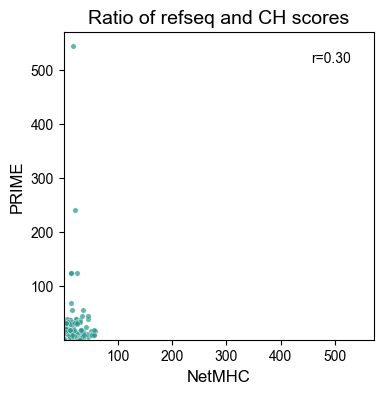

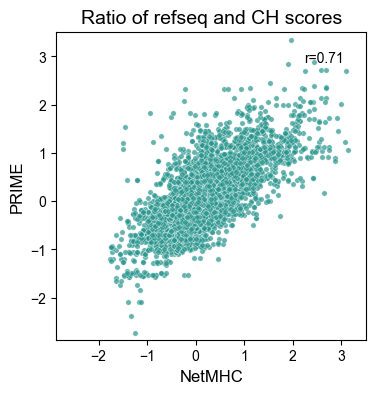

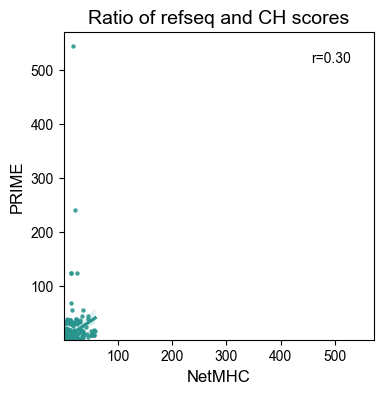

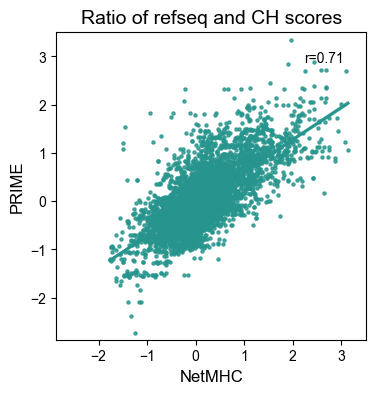

In [123]:

plot_prime_netmhc_comparison_dai(net_wt_mut_ratio, prime_wt_mut_ratio, 'Ratio of refseq and CH scores', color)
plot_prime_netmhc_comparison_dai(net_wt_mut_ratio_log, prime_wt_mut_ratio_log, 'Ratio of refseq and CH scores', color)
plot_prime_netmhc_comparison_dai(net_wt_mut_ratio, prime_wt_mut_ratio, 'Ratio of refseq and CH scores', color, 'regplot')
plot_prime_netmhc_comparison_dai(net_wt_mut_ratio_log, prime_wt_mut_ratio_log, 'Ratio of refseq and CH scores', color, 'regplot')
# in a sense useful to know maybe > to be honest that actually looks a bit better than the raw values for scores 